# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [352]:
# import libraries here; add more as necessary
import math
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC,LinearSVC
import xgboost as xgb
from IPython.display import Image
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [401]:
# load in the data
"""
We get warnings because Columns 18 and 19 are mixed type. To solve this problem we add we force
theses columns types to str by adding dtype={18:'str',19:'str'} in the read_csv statement

"""
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';',dtype={18:'str',19:'str'})
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';',dtype={18:'str',19:'str'})

In [7]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!


In [7]:
pd.set_option('display.max_column',400)

In [402]:
azdias.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   NaN                  NaN   
1          NaN          NaN                  21.0                 11.0   
2          NaN          NaN                  17.0                 10.0   
3          NaN          NaN                  13.0                  1.0   
4          NaN          NaN                  14.0                  3.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           NaN         NaN           NaN                         NaN   
1           0.0         0.0           2.0                        12.0   
2           0.0         0.0           1.0                         7.0   
3           0.0         0.0           0.0                         2.0   
4           0.0         0.0           4.0                         3.0   

   ANZ_TITEL  ARBEIT  BALLRAUM CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  \
0        NaN     NaN       NaN            NaN             NaN             NaN   
1        0.0     3.0       6.0             8A               8              51   
2        0.0     3.0       2.0             4C               4              24   
3        0.0     2.0       4.0             2A               2              12   
4        0.0     4.0       2.0             6B               6              43   

   CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  \
0            2.0                5.0        1.0        1.0        5.0   
1            5.0                1.0        5.0        5.0        2.0   
2            3.0                2.0        4.0        4.0        1.0   
3            2.0                3.0        2.0        2.0        4.0   
4            5.0                3.0        3.0        3.0        3.0   

   CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  \
0        5.0        5.0        5.0                  0                  0   
1        3.0        1.0        1.0                  0                  0   
2        3.0        2.0        2.0                  0                  0   
3        4.0        5.0        3.0                  0                  0   
4        4.0        3.0        3.0                  3                  5   

   D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  D19_BANKEN_LOKAL  \
0                10                  0                 0                 0   
1                10                  0                 0                 0   
2                10                  0                 0                 0   
3                10                  0                 0                 0   
4                 5                  1                 2                 0   

   D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
0                        10                       10   
1                        10                       10   
2                        10                       10   
3                        10                       10   
4                        10                        5   

   D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  \
0                         NaN                0                   0   
1                         NaN                0                   0   
2                         0.0                0                   0   
3                         0.0                0                   0   
4                        10.0                6                   6   

   D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  \
0                    0   

In [8]:
customers.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                  10.0                  1.0   
1          NaN          NaN                   NaN                  NaN   
2          NaN          NaN                   0.0                  1.0   
3          NaN          NaN                   8.0                  0.0   
4          NaN          NaN                  14.0                  7.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           0.0         0.0           2.0                         1.0   
1           NaN         0.0           3.0                         NaN   
2           0.0         0.0           1.0                         1.0   
3           NaN         0.0           0.0                         1.0   
4           0.0         0.0           4.0                         7.0   

   ANZ_TITEL  ARBEIT  BALLRAUM CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  \
0        0.0     1.0       3.0             1A               1              13   
1        0.0     NaN       NaN            NaN             NaN             NaN   
2        0.0     3.0       7.0             5D               5              34   
3        0.0     1.0       7.0             4C               4              24   
4        0.0     3.0       3.0             7B               7              41   

   CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  \
0            5.0                4.0        1.0        1.0        5.0   
1            NaN                NaN        NaN        NaN        NaN   
2            2.0                5.0        2.0        2.0        5.0   
3            2.0                5.0        1.0        1.0        5.0   
4            6.0                4.0        3.0        3.0        3.0   

   CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  \
0        5.0        5.0        5.0                  0                  0   
1        NaN        NaN        NaN                  0                  1   
2        5.0        5.0        5.0                  0                  0   
3        5.0        5.0        5.0                  0                  0   
4        4.0        3.0        3.0                  1                  2   

   D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  D19_BANKEN_LOKAL  \
0                10                  0                 0                 0   
1                 6                  0                 5                 0   
2                10                  0                 0                 0   
3                10                  0                 0                 0   
4                 3                  5                 0                 3   

   D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
0                        10                       10   
1                        10                       10   
2                        10                       10   
3                        10                       10   
4                        10                        7   

   D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  \
0                         0.0                0                   0   
1                         0.0                6                   0   
2                         0.0                0                   0   
3                         0.0                0                   0   
4                         0.0                0                   0   

   D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  \
0                    0   

### Data preprocessing and data preparation.
In this section we will deal with data preparation.
Let first read the metada xlsx files 

In [9]:
vars_infos=pd.read_excel('DIAS Attributes_Values 2017.xlsx')
levels_infos =pd.read_excel('DIAS_Information_Levels_Attributes_2017.xlsx')


In [6]:
levels_infos.drop(['Unnamed: 0'], axis=1)

Information level                    Attribute  \
0                 NaN                     AGER_TYP   
1              Person         ALTERSKATEGORIE_GROB   
2                 NaN                    ANREDE_KZ   
3                 NaN                CJT_GESAMTTYP   
4                 NaN            FINANZ_MINIMALIST   
5                 NaN                FINANZ_SPARER   
6                 NaN             FINANZ_VORSORGER   
7                 NaN               FINANZ_ANLEGER   
8                 NaN        FINANZ_UNAUFFAELLIGER   
9                 NaN             FINANZ_HAUSBAUER   
10                NaN                    FINANZTYP   
11                NaN                  GEBURTSJAHR   
12                NaN              GFK_URLAUBERTYP   
13                NaN             GREEN_AVANTGARDE   
14                NaN                   HEALTH_TYP   
15                NaN          LP_LEBENSPHASE_FEIN   
16                NaN          LP_LEBENSPHASE_GROB   
17                NaN              LP_FAMILIE_FEIN   
18                NaN              LP_FAMILIE_GROB   
19                NaN               LP_STATUS_FEIN   
20                NaN               LP_STATUS_GROB   
21                NaN             NATIONALITAET_KZ   
22                NaN        PRAEGENDE_JUGENDJAHRE   
23                NaN               RETOURTYP_BK_S   
24                NaN                    SEMIO_SOZ   
25                NaN                    SEMIO_FAM   
26                NaN                    SEMIO_REL   
27                NaN                    SEMIO_MAT   
28                NaN                   SEMIO_VERT   
29                NaN                   SEMIO_LUST   
..                ...                          ...   
283               NaN  KBA13_SEG_OBEREMITTELKLASSE   
284               NaN         KBA13_SEG_OBERKLASSE   
285               NaN           KBA13_SEG_SONSTIGE   
286               NaN         KBA13_SEG_SPORTWAGEN   
287               NaN          KBA13_SEG_UTILITIES   
288               NaN                KBA13_SEG_VAN   
289               NaN         KBA13_SEG_WOHNMOBILE   
290               NaN                KBA13_SITZE_4   
291               NaN                KBA13_SITZE_5   
292               NaN                KBA13_SITZE_6   
293               NaN                 KBA13_TOYOTA   
294               NaN                 KBA13_VORB_0   
295               NaN                 KBA13_VORB_1   
296               NaN               KBA13_VORB_1_2   
297               NaN                 KBA13_VORB_2   
298               NaN                 KBA13_VORB_3   
299               NaN                     KBA13_VW   
300               NaN                         PLZ8   
301               NaN                   PLZ8_ANTG1   
302               NaN                   PLZ8_ANTG2   
303               NaN                   PLZ8_ANTG3   
304               NaN                   PLZ8_ANTG4   
305               NaN                  PLZ8_BAUMAX   
306               NaN                     PLZ8_HHZ   
307               NaN                     PLZ8_GBZ   
308         Community                       ARBEIT   
309               NaN                    EINWOHNER   
310               NaN                          GKZ   
311               NaN                  ORTSGR_KLS9   
312               NaN                     RELAT_AB   

                                           Description  \
0                                   best-ager typology   
1                        age through prename analysis    
2                                               gender   
3    Customer-Journey-Typology relating to the pref...   
4           financial typology: low financial interest   
5                      financial typology: money saver   
6                      financial typology: be prepared   
7                         financial typology: investor   
8                     financial typology: unremarkable   
9      financial typology: main focus is the own house   
10        best de

In [10]:
# Let investigate the variables attributes
vars_infos=vars_infos.drop(['Unnamed: 0'], axis=1)
vars_infos.head(25)



Attribute                                   Description  Value  \
0               AGER_TYP                            best-ager typology     -1   
1                    NaN                                           NaN      0   
2                    NaN                                           NaN      1   
3                    NaN                                           NaN      2   
4                    NaN                                           NaN      3   
5   ALTERSKATEGORIE_GROB  age classification through prename analysis   -1, 0   
6                    NaN                                           NaN      1   
7                    NaN                                           NaN      2   
8                    NaN                                           NaN      3   
9                    NaN                                           NaN      4   
10                   NaN                                           NaN      9   
11              ALTER_HH                 main age within the household      0   
12                   NaN                                           NaN      1   
13                   NaN                                           NaN      2   
14                   NaN                                           NaN      3   
15                   NaN                                           NaN      4   
16                   NaN                                           NaN      5   
17                   NaN                                           NaN      6   
18                   NaN                                           NaN      7   
19                   NaN                                           NaN      8   
20                   NaN                                           NaN      9   
21                   NaN                                           NaN     10   
22                   NaN                                           NaN     11   
23                   NaN                                           NaN     12   
24                   NaN                                           NaN     13   

                             Meaning  
0                            unknown  
1         no classification possible  
2                    passive elderly  
3                   cultural elderly  
4          experience-driven elderly  
5                            unknown  
6                         < 30 years  
7                      30 - 45 years  
8                      46 - 60 years  
9                         > 60 years  
10             uniformly distributed  
11  unknown / no main age detectable  
12         01.01.1895 bis 31.12.1899  
13         01.01.1900 bis 31.12.1904  
14         01.01.1905 bis 31.12.1909  
15         01.01.1910 bis 31.12.1914  
16         01.01.1915 bis 31.12.1919  
17         01.01.1920 bis 31.12.1924  
18         01.01.1925 bis 31.12.1929  
19         01.01.1930 bis 31.12.1934  
20         01.01.1935 bis 31.12.1939  
21         01.01.1940 bis 31.12.1944  
22         01.01.1945 bis 31.12.1949  
23         01.01.1950 bis 31.12.1954  
24         01.01.1955 bis 31.12.1959

In the output above, when looking at the **`Attribute`** column we can notice that the table is organized by groups of modalities of the different variables. The first five rows correspond to the modalities of the variable **`AGER_TYP`** for example. 
For each variable only the first row of the attribute column is filled in. The other rows are at **`NaN`** up to the first row of the following variable.

In [11]:
# Replace the NaN in the Attribute column with the name of the corresponding variable.
attribute_feat = vars_infos['Attribute'].fillna(method='ffill')
vars_infos['Attribute'] = attribute_feat

#Replace the NaN in the Attribute column with the name of the corresponding variable.
Description_feat = vars_infos['Description'].fillna(method='ffill')
vars_infos['Description'] = Description_feat
vars_infos.head(30)

Attribute                                   Description  Value  \
0               AGER_TYP                            best-ager typology     -1   
1               AGER_TYP                            best-ager typology      0   
2               AGER_TYP                            best-ager typology      1   
3               AGER_TYP                            best-ager typology      2   
4               AGER_TYP                            best-ager typology      3   
5   ALTERSKATEGORIE_GROB  age classification through prename analysis   -1, 0   
6   ALTERSKATEGORIE_GROB  age classification through prename analysis       1   
7   ALTERSKATEGORIE_GROB  age classification through prename analysis       2   
8   ALTERSKATEGORIE_GROB  age classification through prename analysis       3   
9   ALTERSKATEGORIE_GROB  age classification through prename analysis       4   
10  ALTERSKATEGORIE_GROB  age classification through prename analysis       9   
11              ALTER_HH                 main age within the household      0   
12              ALTER_HH                 main age within the household      1   
13              ALTER_HH                 main age within the household      2   
14              ALTER_HH                 main age within the household      3   
15              ALTER_HH                 main age within the household      4   
16              ALTER_HH                 main age within the household      5   
17              ALTER_HH                 main age within the household      6   
18              ALTER_HH                 main age within the household      7   
19              ALTER_HH                 main age within the household      8   
20              ALTER_HH                 main age within the household      9   
21              ALTER_HH                 main age within the household     10   
22              ALTER_HH                 main age within the household     11   
23              ALTER_HH                 main age within the household     12   
24              ALTER_HH                 main age within the household     13   
25              ALTER_HH                 main age within the household     14   
26              ALTER_HH                 main age within the household     15   
27              ALTER_HH                 main age within the household     16   
28              ALTER_HH                 main age within the household     17   
29              ALTER_HH                 main age within the household     18   

                             Meaning  
0                            unknown  
1         no classification possible  
2                    passive elderly  
3                   cultural elderly  
4          experience-driven elderly  
5                            unknown  
6                         < 30 years  
7                      30 - 45 years  
8                      46 - 60 years  
9                         > 60 years  
10             uniformly distributed  
11  unknown / no main age detectable  
12         01.01.1895 bis 31.12.1899  
13         01.01.1900 bis 31.12.1904  
14         01.01.1905 bis 31.12.1909  
15         01.01.1910 bis 31.12.1914  
16         01.01.1915 bis 31.12.1919  
17         01.01.1920 bis 31.12.1924  
18         01.01.1925 bis 31.12.1929  
19         01.01.1930 bis 31.12.1934  
20         01.01.1935 bis 31.12.1939  
21         01.01.1940 bis 31.12.1944  
22         01.01.1945 bis 31.12.1949  
23         01.01.1950 bis 31.12.1954  
24         01.01.1955 bis 31.12.1959  
25         01.01.1960 bis 31.12.1964  
26         01.01.1965 bis 31.12.1969  
27         01.01.1970 bis 31.12.1974  
28         01.01.1975 bis 31.12.1979  
29         01.01.1980 bis 31.12.1984

Some variable modalities are missing values but coded in a particular way. 
This is the case of cells containing **`unkwnon`** or **`no`** in the column **`meaning`**.
I'm going to find these values and transform them into **`NaN`**

In [12]:
unknown_and_no=vars_infos[(vars_infos['Meaning'].str.contains('unknown')|vars_infos['Meaning'].str.contains('no '))]
df_unknowns=[]
for attribute in unknown_and_no['Attribute'].unique():
    uniq = unknown_and_no.loc[unknown_and_no['Attribute'] == attribute, 'Value'].astype(str).str.cat(sep=',').split(',')
    df_unknowns.append(uniq)
df_unknowns = pd.concat([pd.Series(unknown_and_no['Attribute'].unique()), pd.Series(df_unknowns)], axis=1)
df_unknowns.columns = ['Attribute', 'Unknown']
df_unknowns = pd.DataFrame(df_unknowns)
df_unknowns.head()



Attribute   Unknown
0              AGER_TYP   [-1, 0]
1  ALTERSKATEGORIE_GROB  [-1,  0]
2              ALTER_HH       [0]
3             ANREDE_KZ  [-1,  0]
4              BALLRAUM      [-1]

Now that we have identified the unknown values of the different variables contained in the data, we will be able to replace them with NaN in the `demographics data`

In [16]:
import time
start = time.time()
for row in df_unknowns['Attribute']:
    print(row)
    if row in azdias.columns:
        map_na = df_unknowns.loc[df_unknowns['Attribute'] == row, 'Unknown'].iloc[0]
        idx_na = azdias.loc[:, row].isin(map_na )
        azdias.loc[idx_na, row] = np.NaN
    else:
        continue
print("######------------  ",time.time()-start,"   -----------#######")

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
BALLRAUM
BIP_FLAG
CAMEO_DEUG_2015
CAMEO_DEUINTL_2015
CJT_GESAMTTYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_DIREKT_RZ
D19_BANKEN_GROSS_RZ
D19_BANKEN_LOKAL_RZ
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST_RZ
D19_BEKLEIDUNG_GEH_RZ
D19_BEKLEIDUNG_REST_RZ
D19_BILDUNG_RZ
D19_BIO_OEKO_RZ
D19_BUCH_RZ
D19_DIGIT_SERV_RZ
D19_DROGERIEARTIKEL_RZ
D19_ENERGIE_RZ
D19_FREIZEIT_RZ
D19_GARTEN_RZ
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK_RZ
D19_HAUS_DEKO_RZ
D19_KINDERARTIKEL_RZ
D19_KK_KUNDENTYP
D19_KOSMETIK_RZ
D19_LEBENSMITTEL_RZ
D19_LOTTO_RZ
D19_NAHRUNGSERGAENZUNG_RZ
D19_RATGEBER_RZ
D19_REISEN_RZ
D19_SAMMELARTIKEL_RZ
D19_SCHUHE_RZ
D19_SONSTIGE_RZ
D19_TECHNIK_RZ
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_MOBILE_RZ
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_TELKO_RES


  >The above task take too much time to run. So I save the result in a new DataFrame
 

In [17]:
# assement of percentage of missing values for each column and each row
percent_missing_columns =(azdias.isna().sum(axis=0)/azdias.shape[0])*100
percent_missing_rows =(azdias.isna().sum(axis=1)/azdias.shape[1])*100

Text(20,135.24,'  Threshold: 20.0%')

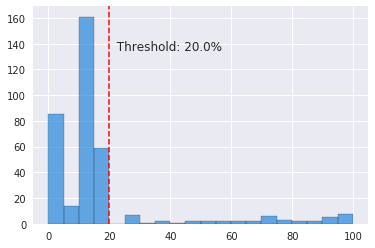

In [18]:
#Histogram of the proportion of missing values per column
sns.set(style="darkgrid")
fig, ax = plt.subplots()
ax.hist(percent_missing_columns, bins=20, color='#1781D9', edgecolor='k', alpha=0.65)
ax.axvline(20, color='r', linestyle='dashed', linewidth=1.5)
vline=20
min_ylim, max_ylim = plt.ylim()
ax.text(vline, max_ylim*0.8, '  Threshold: {:.1f}%'.format(vline))



>As can be seen, the distribution of the percentages of missing values by columns indicates a preponderance of the number of variables with less than **`20 %`** missing values. Conversely, the number of variables with more than **`20 %`** missing values is negligible. I will therefore in the following project remove the variables with more than **`20 %`** missing values in the azdias and customers datasets.

Text(18,299407,'  Threshold: 18.0%')

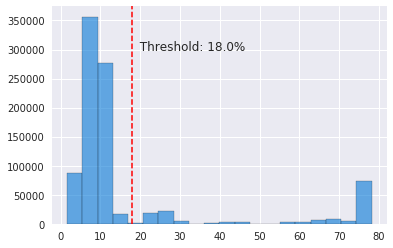

In [19]:
#Histogram of the proportion of missing values per column
sns.set(style="darkgrid")
fig, ax = plt.subplots()
ax.hist(percent_missing_rows, bins=20, color='#1781D9', edgecolor='k', alpha=0.65)
ax.axvline(18, color='r', linestyle='dashed', linewidth=1.5)
vline=18
min_ylim, max_ylim = plt.ylim()
ax.text(vline, max_ylim*0.8, '  Threshold: {:.1f}%'.format(vline))


>As in the analysis of missing values by columns, the analysis of missing values by rows indicates a preponderance of rows with less than **`18 %`** missing values and a negligible share of rows with more than **`18 %`** missing values. I remove the rows with more than **`18 %`** missing values in the rest of the project.


In [20]:
# Let see which columns will be remove 
columns_missing_to_drop=azdias.columns[percent_missing_columns > 20]
print(f'There are {len(list(columns_missing_to_drop))} variables with more that 20 % missing values')
print()
list(columns_missing_to_drop)

There are 47 variables with more that 20 % missing values



['AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_SOZIALES',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'D19_VERSI_ONLINE_QUOTE_12',
 'EXTSEL992',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_BAUMAX',
 'KBA05_MAXVORB',
 'KK_KUNDE

In [21]:
# remove azdias rows with more than 18 % of missing values
rows_to_remove = azdias.index[percent_missing_rows > 18]
azdias.drop(rows_to_remove, inplace=True,axis=0)

In [22]:

print('azdias shape after the remove of {} rows: {}'.format(len(percent_missing_rows)-azdias.shape[0],azdias.shape))



azdias shape after the remove of 154229 rows: (736992, 366)


>154229 rows with more than 18 percent of missing valeurs are droped from the inital azidas dataset
>In the end, I want to have the same variables in the azdias and customers datasets. For this I will identify the columns to delete and create a function that will then be applied to these datasets.


>The other treatment prior to the exploitation of the data within the framework of automatic learning is the recoding of the categorical variables. The categorical variables must be transformed into numerical variables. PCA is only applicable to numerical variables. I will transform categorical variables into dummy variables.  But before doing that I will first remove variables with more than **`20 %`** missing values and categorical variables with more than 10 modalities. The reason for that is that converting to dummy variables increases the number of columns considerably because each modality of each categorical variable becomes a whole column.

In [23]:
num_cols = list(azdias._get_numeric_data().columns)
cat_col  = list(set(azdias.columns) - set(num_cols))

In [24]:
azdias.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
1  910220       NaN         9.0       NaN          NaN          NaN   
2  910225       NaN         9.0      17.0          NaN          NaN   
3  910226       2.0         1.0      13.0          NaN          NaN   
4  910241       NaN         1.0      20.0          NaN          NaN   
5  910244       3.0         1.0      10.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
1          NaN          NaN                  21.0                 11.0   
2          NaN          NaN                  17.0                 10.0   
3          NaN          NaN                  13.0                  1.0   
4          NaN          NaN                  14.0                  3.0   
5          NaN          NaN                  10.0                  5.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
1           0.0         0.0           2.0                        12.0   
2           0.0         0.0           1.0                         7.0   
3           0.0         0.0           0.0                         2.0   
4           0.0         0.0           4.0                         3.0   
5           0.0         0.0           1.0                         2.0   

   ANZ_TITEL  ARBEIT  BALLRAUM CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  \
1        0.0     3.0       6.0             8A               8              51   
2        0.0     3.0       2.0             4C               4              24   
3        0.0     2.0       4.0             2A               2              12   
4        0.0     4.0       2.0             6B               6              43   
5        0.0     2.0       6.0             8C               8              54   

   CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  \
1            5.0                1.0        5.0        5.0        2.0   
2            3.0                2.0        4.0        4.0        1.0   
3            2.0                3.0        2.0        2.0        4.0   
4            5.0                3.0        3.0        3.0        3.0   
5            2.0                5.0        2.0        1.0        5.0   

   CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  \
1        3.0        1.0        1.0                NaN                NaN   
2        3.0        2.0        2.0                NaN                NaN   
3        4.0        5.0        3.0                NaN                NaN   
4        4.0        3.0        3.0                3.0                5.0   
5        5.0        3.0        3.0                NaN                NaN   

   D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  D19_BANKEN_LOKAL  \
1               NaN                  0                 0                 0   
2               NaN                  0                 0                 0   
3               NaN                  0                 0                 0   
4               5.0                  1                 2                 0   
5               NaN                  0                 0                 0   

   D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
1                       NaN                      NaN   
2                       NaN                      NaN   
3                       NaN                      NaN   
4                       NaN                      5.0   
5                       NaN                      NaN   

   D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  \
1                         NaN                0                   0   
2                         NaN                0                   0   
3                         NaN                0                   0   
4                        10.0                6                   6   
5                         NaN                0                   0   

   D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  \
1                    0   

In [25]:
azdias_no_num=list(azdias.select_dtypes(include=['object']).columns)
for col in azdias_no_num:
    print(col)
print()
print("There are {} non numerical variables in the the demographics data".format(len(azdias_no_num)))

CAMEO_DEU_2015
CAMEO_DEUG_2015
CAMEO_INTL_2015
D19_LETZTER_KAUF_BRANCHE
EINGEFUEGT_AM
OST_WEST_KZ

There are 6 non numerical variables in the the demographics data


>As we can see in the above output, we have **`6`** variables that are not numerical variables in the **`demographics data`**. We will in the next step investigate to know what are their types.

>Some variables in the dataset are erroneously considered numeric when in reality they are categorical variables.  So I'm going to isolate these variables and treat them as categorical variables.
Taking this into account, we won't have **`6`** categorical variables but more. 




In [26]:
# By investigating the table of variable information I was able to identify the following variables as being non-numeric
categorical_vars = ['AGER_TYP', 'ANREDE_KZ', 'BIP_FLAG', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP',
'D19_KONSUMTYP', 'D19_KK_KUNDENTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP',
'HAUSHALTSSTRUKTUR', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN',
'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
'NATIONALITAET_KZ', 'OST_WEST_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 'VERS_TYP']
len(categorical_vars)

30

In [27]:
# Let's analyze the previous variables to see if they are binary or multilevel.
# In the case where a variable is multilevel we will try to know if it has more or less than 10 modalities. 
# The rest of the categorical variables will be converted is dummy variables
cols_to_drop=[]
for col in categorical_vars:
    if col in azdias.columns:
        if azdias[col].value_counts().shape[0] > 9 :
            cols_to_drop.append(col)
        print(azdias[col].value_counts())
print()
list(cols_to_drop)

2.0    87974
1.0    77262
3.0    24319
Name: AGER_TYP, dtype: int64
2.0    384103
1.0    352889
Name: ANREDE_KZ, dtype: int64
6B    53980
8A    50743
4C    43980
2D    32896
7A    32619
3C    32551
3D    32159
8B    31252
4A    30246
8C    30134
9D    26729
9B    25878
9C    22911
7B    22908
9A    20042
2C    17738
8D    16672
6E    15593
5D    14065
2B    14038
6C    13863
2A    11919
1D    11455
1A    10158
5A     9715
5B     9686
5C     9049
4B     8283
7C     8121
4D     8051
6A     6411
3A     5870
6D     5754
3B     5707
6F     5048
4E     5003
1E     4780
7D     4427
7E     4374
1C     4012
5F     3939
9E     3841
1B     3815
5E     3240
XX      283
Name: CAMEO_DEU_2015, dtype: int64
4.0    182291
3.0    135153
2.0    133759
5.0    104852
6.0     92101
1.0     84750
Name: CJT_GESAMTTYP, dtype: int64
9.0    232489
1.0    103827
4.0     70561
6.0     50336
3.0     49201
2.0     44739
5.0     22052
Name: D19_KONSUMTYP, dtype: int64
6.0    279248
1.0    183155
5.0     98026
2.0    

['CAMEO_DEU_2015',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_FEIN',
 'PRAEGENDE_JUGENDJAHRE']

In [28]:
## The modalities of the variable OST_WEST_KZ are coded in W and O. I will recode them in 1 and 0
azdias['OST_WEST_KZ'].replace(['W','O'],[1,0], inplace=True)
azdias['OST_WEST_KZ'].value_counts()


1    582040
0    154952
Name: OST_WEST_KZ, dtype: int64

In [29]:
cols_to_dummy=(set(categorical_vars)-set(cols_to_drop))
columns_to_drop =list(columns_missing_to_drop) + list(cols_to_drop)
len(columns_to_drop)


54

In [30]:
azdias.drop(columns_to_drop, inplace=True, axis=1)

In [31]:
azdias.shape


(736992, 312)

> Now let convert to dummy the rest of the categorical variables


In [32]:
for col in cols_to_dummy:
    if col in azdias.columns:
        dummy = pd.get_dummies(azdias[col], prefix = col)
        azdias = pd.concat([azdias, dummy], axis = 1)

In [33]:
print(f'Shape after dummy variables creation:  {azdias.shape}')
# Let remove the orignal variables from which we have created the dummies
for col in cols_to_dummy:
     if col in azdias.columns:
            azdias.drop(col, inplace=True, axis=1)
print()
print(f'Shape after removing the orignal variables from which we have created the dummies  :  {azdias.shape}')


Shape after dummy variables creation:  (736992, 379)

Shape after removing the orignal variables from which we have created the dummies  :  (736992, 364)


In [34]:
# let save the azdias dataframe that we have process into csv as it take more time 
azdias.to_csv('clean_azdias.csv',index=False)

In [9]:
df_unknowns.to_csv('df_unknows.csv',index=False)
pd.DataFrame(columns_to_drop, columns=['columns_to_drop']).to_csv('columns_to_drop.csv', index=False)
pd.DataFrame(columns_to_drop, columns=['cols_to_dummy']).to_csv('cols_to_dummy.csv', index=False)


NameError: name 'columns_to_drop' is not defined

In [13]:

columns_to_drop=pd.read_csv('columns_to_drop.csv')
cols_to_dummy= pd.read_csv('cols_to_dummy.csv')

### Creation of a data cleaning function
> After performing step-by-step processing on the azdias dataset, it would be wise to capitalize on this work by creating a function that would allow the same processing to be applied to the other datasets.
This is what I will do in the next step.

In [374]:
def data_cleaning(df_to_clean, df_vars_unknowns):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: 
        df_to_clean: Customer demographics DataFrame
        df_vars_unknowns: Unknowns DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    for col in df_to_clean.columns:
        if df_to_clean[col].dtype == np.int64:
            df_to_clean[col] = df_to_clean[col].astype(np.float64)
        
    # convert missing value codes into NaNs, ...
    for row in df_vars_unknowns['Attribute']:
        if row in df_to_clean.columns:
            na_map = df_vars_unknowns.loc[df_vars_unknowns['Attribute'] == row, 'Unknown'].iloc[0]
            na_idx = df_to_clean.loc[:, row].isin(na_map)
            df_to_clean.loc[na_idx, row] = np.NaN
        else:
            continue
            
    # Remove columns which have more than 20 %  missing values in the azdias dataframe
    columns_to_drop = pd.read_csv('columns_to_drop.csv')
    cols_to_drop    =list(columns_to_drop['columns_to_drop'])
    for col in cols_to_drop:
        if col in df_to_clean.columns:
            del df_to_clean[col]
    # Remove rows which have  more than 18 % missing values in azdias dataframe.
    percent_missing_rows =(df_to_clean.isna().sum(axis=1)/df_to_clean.shape[1])*100
    rows_to_drop = df_to_clean.index[percent_missing_rows > 18]
    df_to_clean.drop(rows_to_drop, axis=0, inplace = True)
    
    # select, re-encode, and engineer column values
    df_to_clean['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

    cols_to_dummy = list(pd.read_csv('cols_to_dummy.csv').cols_to_dummy)
    
    for col in cols_to_dummy:
        dummy = pd.get_dummies(df_to_clean[col], prefix = col)
        df_to_clean = pd.concat([df_to_clean, dummy], axis = 1)
        
    df_to_clean.drop(cols_to_dummy, axis=1, inplace = True)
    return df_to_clean



To be on the same perimeter as the **`azdias`** dataset, I will drop the three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP') of the **`customers`** dataset 

In [15]:
customers=pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
for col in ['CUSTOMER_GROUP', 'ONLINE_PURCHASE',  'PRODUCT_GROUP']:
    del customers[col]

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
customers.shape

(191652, 366)

In [17]:
#Let apply the data_cleaning function to the customers dataset
clean_customers = data_cleaning(customers, df_unknowns)

In [18]:
clean_customers.head()
clean_customers.shape

(134430, 312)

In [19]:
clean_azdias=pd.read_csv('clean_azdias.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
# Determine the columns that are in the cleaned customers dataframe
# but not the cleaned azdias dataframe (these 3 are expected)
uncommon1=list(clean_customers.columns[~clean_customers.columns.isin(clean_azdias.columns)])

In [21]:
# Determine the columns that are in the cleaned azdias dataframe
# but not the cleaned customers dataframe
uncommon2=list(clean_azdias.columns[~clean_azdias.columns.isin(clean_customers.columns)])

let remove the columns that are not common to both datasets

In [22]:
for col in uncommon1:
    del clean_customers[col]
for col in uncommon2:
    del clean_azdias[col]

In [23]:
clean_customers.columns[~clean_customers.columns.isin(clean_azdias.columns)]

Index([], dtype='object')

In [24]:
clean_azdias.columns[~clean_azdias.columns.isin(clean_customers.columns)]

Index([], dtype='object')

In [25]:
for col in ['CAMEO_DEUG_2015','CAMEO_INTL_2015','EINGEFUEGT_AM']:
    print(clean_azdias[col].value_counts())


8      70361
8.0    58440
6      55172
9      54349
4      52290
6.0    45477
9.0    45052
4.0    43273
2      41962
3      41846
7      39477
2.0    34629
3.0    34441
7.0    32972
5      27303
5.0    22391
1      18687
1.0    15533
X        283
Name: CAMEO_DEUG_2015, dtype: int64
51      69036
51.0    57225
41      47553
24      46443
41.0    39226
24.0    38139
14      31965
43      29670
14.0    26496
43.0    24310
54      23147
25      20303
54.0    19535
25.0    16859
22      16505
22.0    13741
45      13600
13      13314
45.0    11415
55      11121
52      10968
23      10885
13.0    10882
34       9435
55.0     9392
52.0     9074
23.0     8975
15       8808
31       8791
34.0     7870
44       7622
15.0     7427
31.0     7335
12       6562
44.0     6241
32       5399
35       5374
12.0     5357
33       4946
35.0     4319
32.0     4287
33.0     4103
XX        283
Name: CAMEO_INTL_2015, dtype: int64
1992-02-10 00:00:00    372097
1992-02-12 00:00:00    187277
1995-02-07 00:00:00

In [26]:
# As we can see in the ouput above, the columns CAMEO_DEUG_2015 and CAMEO_INTL_2015 
# have string values of "X" and "XX" and  EINGEFUEGT_AM has a similar issue. I will remove these columns 
# in order to perform the next steps  
for col in ['CAMEO_DEUG_2015','CAMEO_INTL_2015','EINGEFUEGT_AM']:
    del clean_azdias[col]
    del clean_customers[col]

In [27]:
print(f'final customers shape: {clean_customers.shape}')
print()
print(f'final azidas shape: {clean_azdias.shape}')

final customers shape: (134430, 294)

final azidas shape: (736992, 294)


In [28]:
# Impute the missing values using the mean as  
imputer = Imputer(strategy='mean')
clean_azdias = pd.DataFrame(imputer.fit_transform(clean_azdias), columns = clean_azdias.columns)
clean_customers = pd.DataFrame(imputer.transform(clean_customers), columns = clean_customers.columns)

In [29]:
# scalling
scaler = StandardScaler()
clean_azdias = pd.DataFrame(scaler.fit_transform(clean_azdias), columns = clean_azdias.columns)
clean_customers = pd.DataFrame(scaler.fit_transform(clean_customers), columns = clean_customers.columns)



In [30]:
clean_azdias.head()

LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  \
0  1.057678    1.262163             0.186905     -0.125867    -0.29911   
1  1.057698    1.262163             0.120714     -0.125867    -0.29911   
2  1.057702   -0.934352            -0.475010     -0.125867    -0.29911   
3  1.057760   -0.934352            -0.342627     -0.125867    -0.29911   
4  1.057771   -0.934352            -0.210244     -0.125867    -0.29911   

   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL    ARBEIT  BALLRAUM  \
0      0.224505                    0.335500  -0.060673 -0.179348  0.850314   
1     -0.634591                   -0.031798  -0.060673 -0.179348 -0.980218   
2     -1.493687                   -0.399097  -0.060673 -1.185227 -0.064952   
3      1.942698                   -0.325637  -0.060673  0.826531 -0.980218   
4     -0.634591                   -0.399097  -0.060673 -1.185227  0.850314   

   CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  CJT_TYP_4  CJT_TYP_5  \
0          -1.502099   1.286301   1.396088  -0.919905  -0.187288  -1.646742   
1          -0.825742   0.544754   0.671875  -1.645955  -0.187288  -0.908571   
2          -0.149385  -0.938340  -0.776551   0.532196   0.554441   1.305939   
3          -0.149385  -0.196793  -0.052338  -0.193855   0.554441  -0.170401   
4           1.203329  -0.938340  -1.500764   1.258246   1.296171  -0.170401   

   CJT_TYP_6  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  D19_BANKEN_LOKAL  \
0  -1.802270          -0.466554         -0.362087         -0.136557   
1  -1.046415          -0.466554         -0.362087         -0.136557   
2  -0.290560          -0.466554         -0.362087         -0.136557   
3  -0.290560           0.013779          0.811855         -0.136557   
4  -0.290560          -0.466554         -0.362087         -0.136557   

   D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  D19_BEKLEIDUNG_REST  D19_BILDUNG  \
0        -0.292971           -0.315529            -0.530296    -0.311717   
1        -0.292971           -0.315529            -0.530296     3.191421   
2        -0.292971           -0.315529            -0.530296    -0.311717   
3         3.546392            3.445421            -0.102628     3.191421   
4        -0.292971           -0.315529            -0.530296    -0.311717   

   D19_BIO_OEKO  D19_BUCH_CD  D19_DIGIT_SERV  D19_DROGERIEARTIKEL  \
0     -0.216741    -0.664970       -0.197166            -0.400004   
1     -0.216741    -0.664970       -0.197166            -0.400004   
2     -0.216741     1.621491       -0.197166            -0.400004   
3     -0.216741     1.621491       -0.197166             0.152403   
4     -0.216741    -0.664970       -0.197166            -0.400004   

   D19_ENERGIE  D19_FREIZEIT  D19_GARTEN  D19_HANDWERK  D19_HAUS_DEKO  \
0    -0.273441     -0.355399   -0.219353     -0.422083      -0.497714   
1    -0.273441     -0.355399   -0.219353     -0.422083      -0.497714   
2    -0.273441     -0.355399   -0.219353     -0.422083      -0.497714   
3     3.292342     -0.355399   -0.219353     -0.422083       1.765135   
4     1.866029     -0.355399   -0.219353     -0.422083      -0.497714   

   D19_KINDERARTIKEL  D19_KONSUMTYP_MAX  D19_KOSMETIK  D19_LEBENSMITTEL  \
0          -0.437507           1.064628     -0.466796         -0.253609   
1          -0.437507           0.753597      1.984449         -0.253609   
2          -0.437507           0.753597     -0.466796         -0.253609   
3          -0.437507          -1.423617     -0.466796         -0.253609   
4          -0.437507          -1.423617     -0.466796         -0.253609   

   D19_NAHRUNGSERGAENZUNG  D19_RATGEBER  D19_REISEN  D19_SAMMELARTIKEL  \
0               -0.218108     -0.326059   -0.480968          -0.352444   
1               -0.218108     -0.326059   -0.480968          -0.352444   
2               -0.218108     -0.326059    1.985205           2.817342   
3               -0.218108     -0.326059   -0.480968          -0.352444   
4               -0.218108     -0.326059   -0.480968         

In [31]:
clean_customers.head()

LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  \
0 -1.559594   -0.368334            -0.275728     -0.126521   -0.265213   
1  0.864732   -0.368334            -0.275728     -0.126521   -0.265213   
2  0.864750   -0.368334            -0.348343     -0.049185   -0.265213   
3  0.864768   -0.368334             0.159963     -0.126521   -0.265213   
4  0.865021   -0.368334            -0.275728     -0.126521   -0.265213   

   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL    ARBEIT  BALLRAUM  \
0     -0.206644                    -0.25881  -0.134632 -1.815082 -0.611897   
1     -0.921312                    -0.25881  -0.134632  0.167365  1.278255   
2     -1.635980                    -0.25881  -0.134632 -1.815082  1.278255   
3      1.222692                     0.18288  -0.134632  0.167365 -0.611897   
4     -0.206644                    -0.25881  -0.134632  0.167365  1.278255   

   CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  CJT_TYP_4  CJT_TYP_5  \
0           0.192630  -0.965624  -0.871759   0.663425   0.685418   0.657380   
1           0.893533  -0.006068   0.162391   0.663425   0.685418   0.657380   
2           0.893533  -0.965624  -0.871759   0.663425   0.685418   0.657380   
3           0.192630   0.953489   1.196540  -1.479703  -0.228723  -1.390073   
4          -0.508272  -0.965624  -0.871759   0.663425   0.685418   0.657380   

   CJT_TYP_6  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  D19_BANKEN_LOKAL  \
0   0.616024          -0.427116         -0.342204         -0.167318   
1   0.616024          -0.427116         -0.342204         -0.167318   
2   0.616024          -0.427116         -0.342204         -0.167318   
3  -1.480651           2.087303         -0.342204          2.743967   
4   0.616024          -0.427116         -0.342204         -0.167318   

   D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  D19_BEKLEIDUNG_REST  D19_BILDUNG  \
0        -0.333951           -0.555336            -0.727321    -0.539186   
1        -0.333951           -0.555336            -0.727321     1.889998   
2        -0.333951           -0.555336            -0.727321    -0.539186   
3        -0.333951           -0.555336             1.433864    -0.539186   
4        -0.333951           -0.555336             1.433864    -0.539186   

   D19_BIO_OEKO  D19_BUCH_CD  D19_DIGIT_SERV  D19_DROGERIEARTIKEL  \
0      -0.36141     0.968642       -0.230847            -0.481111   
1      -0.36141    -1.154260       -0.230847            -0.481111   
2      -0.36141     0.968642       -0.230847            -0.481111   
3      -0.36141    -0.446626       -0.230847             1.443663   
4      -0.36141     0.614825       -0.230847            -0.481111   

   D19_ENERGIE  D19_FREIZEIT  D19_GARTEN  D19_HANDWERK  D19_HAUS_DEKO  \
0    -0.366976     -0.437403   -0.289085     -0.708654       1.501333   
1    -0.366976     -0.437403   -0.289085     -0.708654      -0.768144   
2    -0.366976     -0.437403   -0.289085     -0.708654      -0.768144   
3    -0.366976      2.479631   -0.289085     -0.708654       1.501333   
4    -0.366976     -0.437403   -0.289085      1.351561      -0.768144   

   D19_KINDERARTIKEL  D19_KONSUMTYP_MAX  D19_KOSMETIK  D19_LEBENSMITTEL  \
0          -0.566185          -0.347574     -0.756187          2.679043   
1          -0.566185          -0.347574     -0.756187         -0.393493   
2          -0.566185          -0.347574     -0.756187         -0.393493   
3          -0.566185           0.684269     -0.756187          2.166954   
4          -0.566185          -0.347574     -0.756187         -0.393493   

   D19_NAHRUNGSERGAENZUNG  D19_RATGEBER  D19_REISEN  D19_SAMMELARTIKEL  \
0               -0.360771     -0.483568   -0.790267           1.454450   
1               -0.360771     -0.483568    1.197792           1.454450   
2                2.291300     -0.483568   -0.790267          -0.691197   
3               -0.360771      2.249633   -0.790267           1.454450   
4               -0.360771     -0.483568   -0.790267         


>I impute the missing data using the average of each column to replace the missing value. This sounds very basic. However I tried to use the median and the nearest neighbor K method but I'm dealing with a memory problem. When I execute the code I get a MemoryError error.
> After the imputation I standardize the features by using the **`sklearn StandardScaler()`**. The goal is to give the same importance to all the features.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### PCA
>We've done the hard work of cleaning, preparation and transformation of the data. Now it's time to perform the unsupervised learning model, the PCA  in our  case.

In [32]:
def make_pca(n_components, dataset):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           dataset - the dataset you would like to transform. This dataset must be cleaned and standardize before performing 
           the PCA

    OUTPUT: pca - the pca object created after fitting the data
            fit_pca - the transformed  matrix with new number of components
    '''
    pca = PCA(n_components, svd_solver='full')
    fit_pca = pca.fit_transform(dataset)
    return pca, fit_pca


In [33]:
## Let apply this the make_pca function to the azdias cleaned dataset
n_components= clean_azdias.shape[1] -1
azdias_pca, azdias_fit_pca= make_pca(n_components,clean_azdias)

In [34]:
# The number of component
print('The number of components computed by the PCA model:  {}'.format(azdias_pca.n_components_))

The number of components computed by the PCA model:  293


In [35]:
# The explained variance per compement
print(f'The explained variance per compement: {azdias_pca.explained_variance_}')

The explained variance per compement: [  2.41938981e+01   1.72476608e+01   1.35674154e+01   9.54871435e+00
   8.01842393e+00   6.53981087e+00   6.07643207e+00   5.82414210e+00
   5.15136015e+00   4.86629739e+00   4.46057555e+00   3.97900248e+00
   3.49558329e+00   3.31589406e+00   3.16694743e+00   3.03556545e+00
   2.85287261e+00   2.71320055e+00   2.66408027e+00   2.61028373e+00
   2.37712386e+00   2.32365831e+00   2.23562330e+00   2.12913215e+00
   2.06724692e+00   2.00360964e+00   1.98031799e+00   1.87850980e+00
   1.82896060e+00   1.80609831e+00   1.75340386e+00   1.74004611e+00
   1.67865434e+00   1.64509105e+00   1.56591395e+00   1.53379654e+00
   1.49250633e+00   1.47292916e+00   1.44166037e+00   1.42922567e+00
   1.39014058e+00   1.37701503e+00   1.37093175e+00   1.32960073e+00
   1.32859369e+00   1.30826640e+00   1.29422627e+00   1.24802136e+00
   1.24404053e+00   1.21390820e+00   1.20182050e+00   1.16878700e+00
   1.15800040e+00   1.13875058e+00   1.13122574e+00   1.12073514e

In [400]:
### Let create a function to plot the scree
def scree_plot(pca, fit_pca,*args, **kwargs):
    #scree plot
    plt.style.use('ggplot')
    n= fit_pca.shape[0]
    p= fit_pca.shape[1] 
    eigval = pca.singular_values_**2/n
    plt.figure(figsize=(15,10))
    plt.subplot(211)
    vline=kwargs.get('vline', None)
    #plt.rcParams["figure.figsize"] = (18,20)
    plt.plot(np.arange(1,p+1),eigval, 'r--')
    plt.plot(np.arange(1,p+1),eigval, 'bo')
    plt.title("Scree plot")
    plt.ylabel("Eigen values")
    plt.xlabel("Factor number")
    plt.xticks(np.arange(0, 300, 10.0))
    if vline:
        min_ylim, max_ylim = plt.ylim()
        plt.axvline(vline, color='g', linestyle='dashed', linewidth=1.)
        plt.text(vline, max_ylim*0.8, '  Threshold: {:.1f}'.format(vline))

    
    # The graph of the cumulative variance restored according to the number of factors 
    plt.subplot(212)
    plt.plot(np.arange(1,p+1),np.cumsum(pca.explained_variance_ratio_),'r--')
    plt.plot(np.arange(1,p+1),np.cumsum(pca.explained_variance_ratio_),'bo')
    plt.title("Explained variance vs. # of factors")
    plt.ylabel("Cumsum explained variance ratio")
    plt.xlabel("Factor number")
    plt.show()
    plt.savefig('scree_plot1.png')
    
   #===========================================================================================
def scree_plot2(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15,10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals,'r--')
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.savefig('scree_plot2.png')

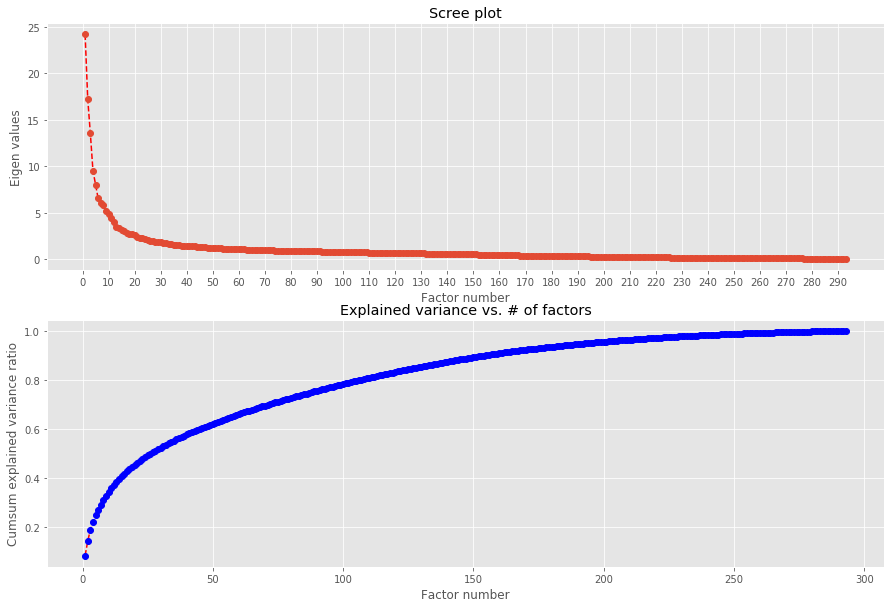

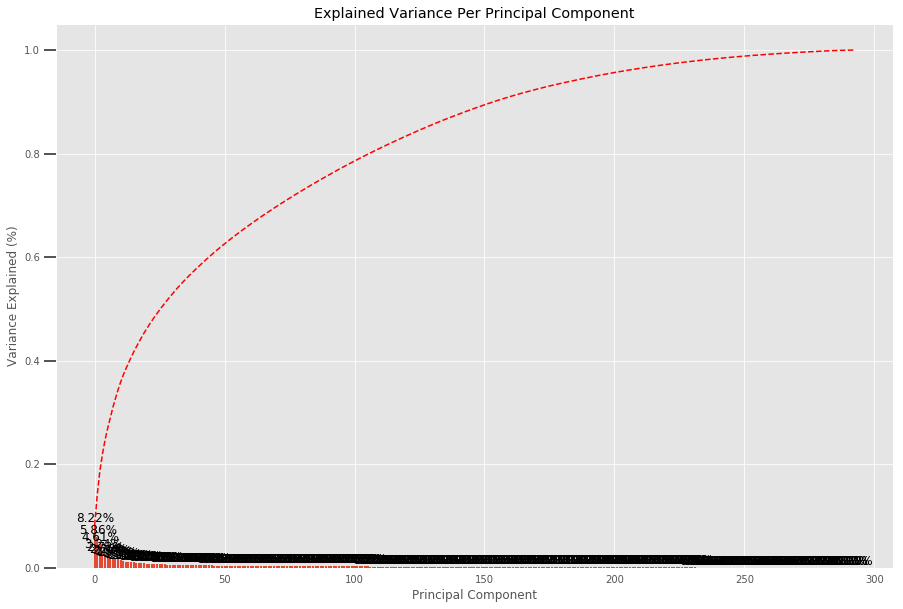

In [399]:
scree_plot(azdias_pca, azdias_fit_pca)
scree_plot2(azdias_pca)


> In the first graph, we can see that the change of the eigenvalue curve is made from p= 12  principal components. But when we see variance cumulative curve we notice that with 12 principal components we capture less than 50 %  on the variance.
Later we will chose more than 12 compement to have at least 90 % of variance.

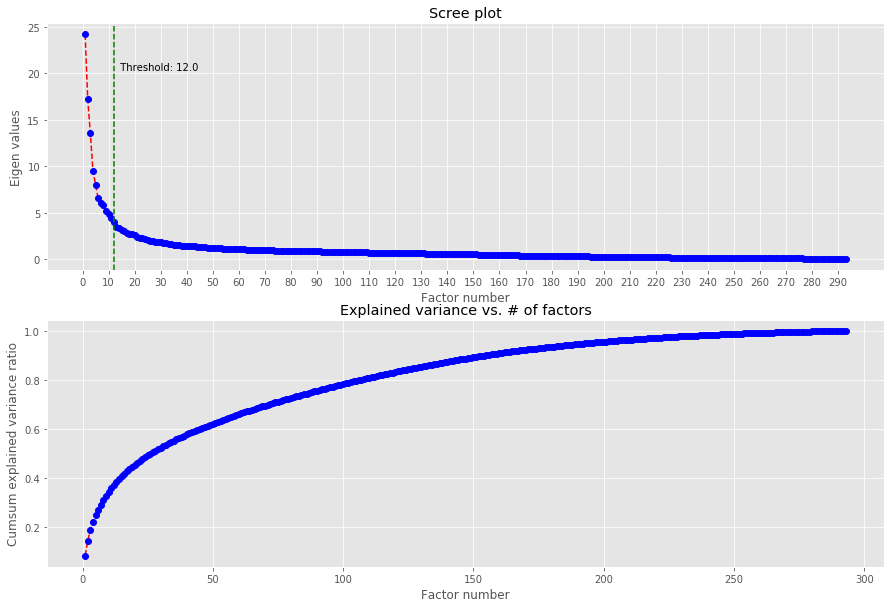

In [395]:
scree_plot(azdias_pca, azdias_fit_pca, vline=12)

I we use the **` optimal_n_componemt`** I define above to target at least 90 % of cumulative variance and show how many componement to keep.

In [39]:
def optimal_n_componemt(pca, min_variance):
    
    ''' return the minimal number of the first most important components that 
        able to capture at least nin_variance
        
        INPUT: pca - the result of instantian of PCA in scikit learn
               min_variance: the minimum of cumulative variance we want to target
        
        OUTPUT: The optimal number of component
               
    '''
    cum_var=np.cumsum(pca.explained_variance_ratio_)
    L1=len(azdias_pca.explained_variance_ratio_)
    L2=len(azdias_pca.explained_variance_ratio_[cum_var > min_variance])
    return L1-L2 + 1

In [55]:
# Apply optimal_n_componemt with nim_variance =90%
optim_component=optimal_n_componemt(azdias_pca, 0.90)
print(optim_component)

155


Let perform a 155 componemt PCA on the azdias dataset

In [56]:
azdias_pca_155, azdias_fit_pca_155=make_pca(optim_component, clean_azdias)

In [57]:
#=======================================================================================================
def get_important_features(transformed_features, components_, columns):
    """
    This function will return the most "important" 
    features so we can determine which have the most
    effect on multi-dimensional scaling
    """
    num_columns = len(columns)

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by importance:\n", important_features)
    return important_features

##### Interpreting Components
Before the Kmeans clustering, I will try to find an interpretation of the components, at least the most important ones.

In [58]:
main_features=get_important_features(azdias_fit_pca_155, azdias_pca_155.components_, clean_azdias.columns.values)

Features by importance:
 [(3.129090070729175, 'KBA13_HERST_BMW_BENZ'), (2.6842856091654017, 'KBA13_MERCEDES'), (2.6728354077317675, 'KBA13_SEG_OBEREMITTELKLASSE'), (2.6187585888080425, 'EWDICHTE'), (2.605511250972791, 'KBA13_BMW'), (2.5437577071785475, 'KBA13_SITZE_5'), (2.4832330185919966, 'ORTSGR_KLS9'), (2.4574916647013905, 'KBA13_SITZE_4'), (2.428905722381087, 'PLZ8_ANTG3'), (2.4282620815150673, 'KBA13_ANTG3'), (2.4100141598124494, 'KBA13_SEG_SPORTWAGEN'), (2.3798360487292625, 'GEMEINDETYP'), (2.373243418044805, 'PLZ8_ANTG1'), (2.371827771917586, 'KBA13_ANTG1'), (2.3663040189507663, 'KBA13_ALTERHALTER_60'), (2.3519717224661085, 'KBA13_ANTG4'), (2.3441485223581853, 'KBA13_AUTOQUOTE'), (2.339979314287126, 'MOBI_REGIO'), (2.3378763601237598, 'KBA13_BAUMAX'), (2.331413176789747, 'PLZ8_ANTG4'), (2.302258872947606, 'PLZ8_BAUMAX'), (2.2804037148014826, 'KBA13_SEG_KLEINWAGEN'), (2.2502302378559405, 'KBA13_KMH_140_210'), (2.2305572770873403, 'KBA13_KMH_211'), (2.2115310252207943, 'KBA05_HER

In [59]:
# print the top 10 main features
L=[main_features[feature][1] for feature in range(10)]
print('The 10 main features are:\n')
for i in L:
    print(i)

The 10 main features are:

KBA13_HERST_BMW_BENZ
KBA13_MERCEDES
KBA13_SEG_OBEREMITTELKLASSE
EWDICHTE
KBA13_BMW
KBA13_SITZE_5
ORTSGR_KLS9
KBA13_SITZE_4
PLZ8_ANTG3
KBA13_ANTG3


In [61]:
#=================================================================================================================
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# The pca_results function was taken from the class notes and altered

def pca_results(clean_dataset, pca, component_number):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results where figure 1 shows all features sorted
    and figure 2 shows the top 3 negative and positive features.
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = clean_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Create a bar plot visualization for 1st figure (all columns sorted)
    fig1, ax1 = plt.subplots(figsize = (15,8))

    # Plot the feature weights as a function of the components
    components.iloc[component_number-1, :].sort_values().plot(ax = ax1, kind = 'bar');
    ax1.set_ylabel("Feature Weights")
    ax1.set_xticklabels(components.iloc[component_number-1, :].sort_values().index, rotation=90)
   
    # Create a bar plot visualization for 2nd figure (top and bottom 3 columns)
    fig2, ax2 = plt.subplots(figsize = (6,3))
    
    # Plot the feature weights as a function of the components
    components.iloc[component_number-1, :].sort_values().iloc[[0, 1, 2, -3, -2, -1]].plot(ax = ax2, kind = 'bar');
    ax2.set_ylabel("Feature Weights")
    ax2.set_xticklabels(components.iloc[component_number-1, :].sort_values().index, rotation=90)

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)



Explained Variance     LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  \
Dimension 1                0.0823 -0.0311      0.0611               0.0848   
Dimension 2                0.0587  0.0777      0.0127               0.0218   
Dimension 3                0.0461 -0.0266     -0.0505               0.0169   
Dimension 4                0.0325 -0.0714     -0.1167               0.0078   
Dimension 5                0.0273 -0.1082      0.0621               0.0126   
Dimension 6                0.0222 -0.0083     -0.0207               0.0256   
Dimension 7                0.0207 -0.0226     -0.0108              -0.0169   
Dimension 8                0.0198  0.0223      0.0193              -0.0050   
Dimension 9                0.0175 -0.0894      0.0273              -0.0692   
Dimension 10               0.0166  0.0022      0.0137              -0.0389   
Dimension 11               0.0152 -0.0220     -0.0063               0.0467   
Dimension 12               0.0135  0.0202     -0.0009               0.0255   
Dimension 13               0.0119 -0.0946      0.0045               0.0375   
Dimension 14               0.0113  0.0477     -0.0031              -0.0190   
Dimension 15               0.0108 -0.0406      0.0002               0.0829   
Dimension 16               0.0103  0.0436     -0.0034               0.1484   
Dimension 17               0.0097 -0.0207      0.0025               0.1254   
Dimension 18               0.0092  0.0562     -0.0046               0.0687   
Dimension 19               0.0091  0.0342     -0.0076              -0.0396   
Dimension 20               0.0089 -0.1017     -0.0132               0.1886   
Dimension 21               0.0081  0.0028      0.0895               0.0923   
Dimension 22               0.0079  0.0227     -0.0270               0.0462   
Dimension 23               0.0076  0.0232      0.0459              -0.0258   
Dimension 24               0.0072  0.0159     -0.0001               0.0978   
Dimension 25               0.0070  0.0327     -0.0448               0.0969   
Dimension 26               0.0068  0.0055      0.0088               0.0055   
Dimension 27               0.0067 -0.0114     -0.0028               0.0889   
Dimension 28               0.0064 -0.0068      0.0383               0.1795   
Dimension 29               0.0062 -0.0286     -0.0851               0.0669   
Dimension 30               0.0061 -0.0163      0.0375               0.2267   
...                           ...     ...         ...                  ...   
Dimension 126              0.0022 -0.0077     -0.1007              -0.0089   
Dimension 127              0.0022 -0.0304      0.2623              -0.0160   
Dimension 128              0.0022 -0.1288     -0.2152              -0.0329   
Dimension 129              0.0021  0.0164      0.1724              -0.0189   
Dimension 130              0.0021  0.0664      0.1001               0.0024   
Dimension 131              0.0021 -0.0406      0.2451              -0.0625   
Dimension 132              0.0021  0.2368     -0.1690              -0.0762   
Dimension 133              0.0021 -0.2247     -0.2769              -0.0958   
Dimension 134              0.0020  0.0744     -0.0386              -0.0470   
Dimension 135              0.0020 -0.0082      0.0116              -0.0418   
Dimension 136              0.0020  0.2834      0.0532              -0.1345   
Dimension 137              0.0020  0.0619      0.0964              -0.0867   
Dimension 138              0.0019  0.0263      0.0512               0.0124   
Dimension 139              0.0019 -0.1812      0.0150              -0.0933   
Dimension 140              0.0019  0.2078     -0.0607               0.0003   
Dimension 141              0.0019  0.0151     -0.1130              -0.0803   
Dimension 142              0.0019 -0.0018      0.1451               0.0145   
Dimension 143              0.0019 -0.0099     -0.1741              -0.0098   
Dimension 144              0.0019 -0.1418      0.0720              -0.1079   
Dimension 145              0.0018  0.

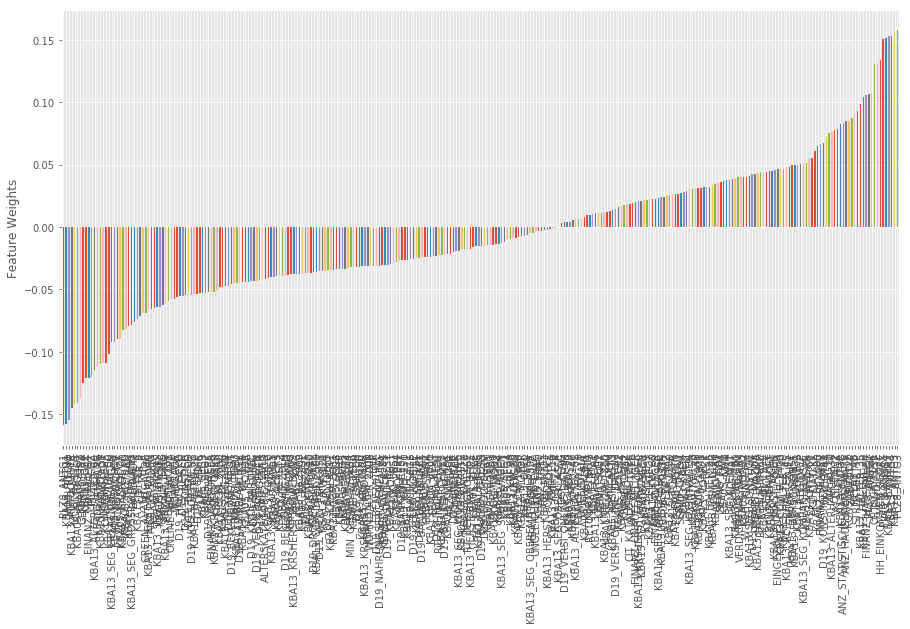

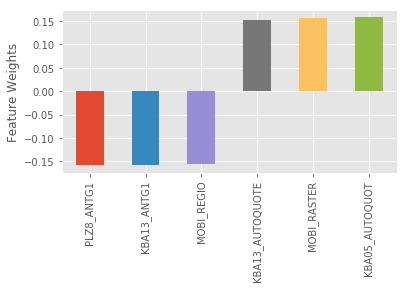

In [95]:

# coordinates of the main variables on the first component
pca_results(clean_azdias, azdias_pca_155, 1)


Explained Variance     LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  \
Dimension 1                0.0823 -0.0311      0.0611               0.0848   
Dimension 2                0.0587  0.0777      0.0127               0.0218   
Dimension 3                0.0461 -0.0266     -0.0505               0.0169   
Dimension 4                0.0325 -0.0714     -0.1167               0.0078   
Dimension 5                0.0273 -0.1082      0.0621               0.0126   
Dimension 6                0.0222 -0.0083     -0.0207               0.0256   
Dimension 7                0.0207 -0.0226     -0.0108              -0.0169   
Dimension 8                0.0198  0.0223      0.0193              -0.0050   
Dimension 9                0.0175 -0.0894      0.0273              -0.0692   
Dimension 10               0.0166  0.0022      0.0137              -0.0389   
Dimension 11               0.0152 -0.0220     -0.0063               0.0467   
Dimension 12               0.0135  0.0202     -0.0009               0.0255   
Dimension 13               0.0119 -0.0946      0.0045               0.0375   
Dimension 14               0.0113  0.0477     -0.0031              -0.0190   
Dimension 15               0.0108 -0.0406      0.0002               0.0829   
Dimension 16               0.0103  0.0436     -0.0034               0.1484   
Dimension 17               0.0097 -0.0207      0.0025               0.1254   
Dimension 18               0.0092  0.0562     -0.0046               0.0687   
Dimension 19               0.0091  0.0342     -0.0076              -0.0396   
Dimension 20               0.0089 -0.1017     -0.0132               0.1886   
Dimension 21               0.0081  0.0028      0.0895               0.0923   
Dimension 22               0.0079  0.0227     -0.0270               0.0462   
Dimension 23               0.0076  0.0232      0.0459              -0.0258   
Dimension 24               0.0072  0.0159     -0.0001               0.0978   
Dimension 25               0.0070  0.0327     -0.0448               0.0969   
Dimension 26               0.0068  0.0055      0.0088               0.0055   
Dimension 27               0.0067 -0.0114     -0.0028               0.0889   
Dimension 28               0.0064 -0.0068      0.0383               0.1795   
Dimension 29               0.0062 -0.0286     -0.0851               0.0669   
Dimension 30               0.0061 -0.0163      0.0375               0.2267   
...                           ...     ...         ...                  ...   
Dimension 126              0.0022 -0.0077     -0.1007              -0.0089   
Dimension 127              0.0022 -0.0304      0.2623              -0.0160   
Dimension 128              0.0022 -0.1288     -0.2152              -0.0329   
Dimension 129              0.0021  0.0164      0.1724              -0.0189   
Dimension 130              0.0021  0.0664      0.1001               0.0024   
Dimension 131              0.0021 -0.0406      0.2451              -0.0625   
Dimension 132              0.0021  0.2368     -0.1690              -0.0762   
Dimension 133              0.0021 -0.2247     -0.2769              -0.0958   
Dimension 134              0.0020  0.0744     -0.0386              -0.0470   
Dimension 135              0.0020 -0.0082      0.0116              -0.0418   
Dimension 136              0.0020  0.2834      0.0532              -0.1345   
Dimension 137              0.0020  0.0619      0.0964              -0.0867   
Dimension 138              0.0019  0.0263      0.0512               0.0124   
Dimension 139              0.0019 -0.1812      0.0150              -0.0933   
Dimension 140              0.0019  0.2078     -0.0607               0.0003   
Dimension 141              0.0019  0.0151     -0.1130              -0.0803   
Dimension 142              0.0019 -0.0018      0.1451               0.0145   
Dimension 143              0.0019 -0.0099     -0.1741              -0.0098   
Dimension 144              0.0019 -0.1418      0.0720              -0.1079   
Dimension 145              0.0018  0.

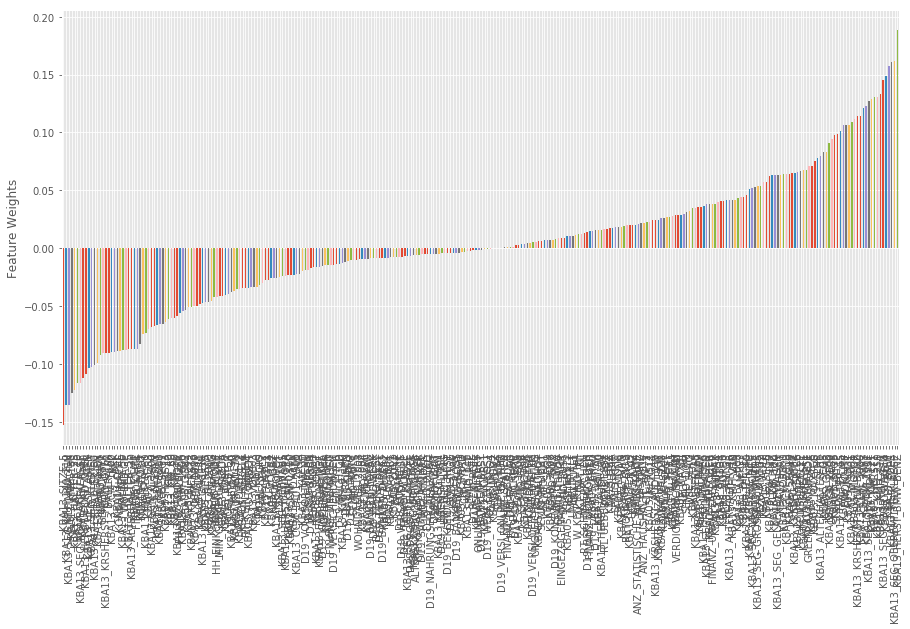

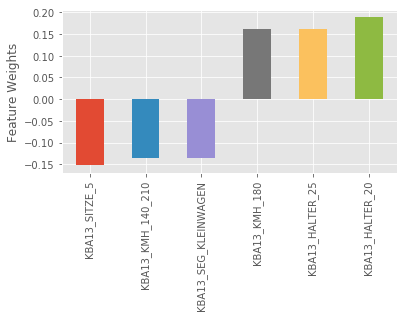

In [62]:

# coordinates of the main variables on the  component 2
pca_results(clean_azdias, azdias_pca_155, 2)

Explained Variance     LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  \
Dimension 1                0.0823 -0.0311      0.0611               0.0848   
Dimension 2                0.0587  0.0777      0.0127               0.0218   
Dimension 3                0.0461 -0.0266     -0.0505               0.0169   
Dimension 4                0.0325 -0.0714     -0.1167               0.0078   
Dimension 5                0.0273 -0.1082      0.0621               0.0126   
Dimension 6                0.0222 -0.0083     -0.0207               0.0256   
Dimension 7                0.0207 -0.0226     -0.0108              -0.0169   
Dimension 8                0.0198  0.0223      0.0193              -0.0050   
Dimension 9                0.0175 -0.0894      0.0273              -0.0692   
Dimension 10               0.0166  0.0022      0.0137              -0.0389   
Dimension 11               0.0152 -0.0220     -0.0063               0.0467   
Dimension 12               0.0135  0.0202     -0.0009               0.0255   
Dimension 13               0.0119 -0.0946      0.0045               0.0375   
Dimension 14               0.0113  0.0477     -0.0031              -0.0190   
Dimension 15               0.0108 -0.0406      0.0002               0.0829   
Dimension 16               0.0103  0.0436     -0.0034               0.1484   
Dimension 17               0.0097 -0.0207      0.0025               0.1254   
Dimension 18               0.0092  0.0562     -0.0046               0.0687   
Dimension 19               0.0091  0.0342     -0.0076              -0.0396   
Dimension 20               0.0089 -0.1017     -0.0132               0.1886   
Dimension 21               0.0081  0.0028      0.0895               0.0923   
Dimension 22               0.0079  0.0227     -0.0270               0.0462   
Dimension 23               0.0076  0.0232      0.0459              -0.0258   
Dimension 24               0.0072  0.0159     -0.0001               0.0978   
Dimension 25               0.0070  0.0327     -0.0448               0.0969   
Dimension 26               0.0068  0.0055      0.0088               0.0055   
Dimension 27               0.0067 -0.0114     -0.0028               0.0889   
Dimension 28               0.0064 -0.0068      0.0383               0.1795   
Dimension 29               0.0062 -0.0286     -0.0851               0.0669   
Dimension 30               0.0061 -0.0163      0.0375               0.2267   
...                           ...     ...         ...                  ...   
Dimension 126              0.0022 -0.0077     -0.1007              -0.0089   
Dimension 127              0.0022 -0.0304      0.2623              -0.0160   
Dimension 128              0.0022 -0.1288     -0.2152              -0.0329   
Dimension 129              0.0021  0.0164      0.1724              -0.0189   
Dimension 130              0.0021  0.0664      0.1001               0.0024   
Dimension 131              0.0021 -0.0406      0.2451              -0.0625   
Dimension 132              0.0021  0.2368     -0.1690              -0.0762   
Dimension 133              0.0021 -0.2247     -0.2769              -0.0958   
Dimension 134              0.0020  0.0744     -0.0386              -0.0470   
Dimension 135              0.0020 -0.0082      0.0116              -0.0418   
Dimension 136              0.0020  0.2834      0.0532              -0.1345   
Dimension 137              0.0020  0.0619      0.0964              -0.0867   
Dimension 138              0.0019  0.0263      0.0512               0.0124   
Dimension 139              0.0019 -0.1812      0.0150              -0.0933   
Dimension 140              0.0019  0.2078     -0.0607               0.0003   
Dimension 141              0.0019  0.0151     -0.1130              -0.0803   
Dimension 142              0.0019 -0.0018      0.1451               0.0145   
Dimension 143              0.0019 -0.0099     -0.1741              -0.0098   
Dimension 144              0.0019 -0.1418      0.0720              -0.1079   
Dimension 145              0.0018  0.

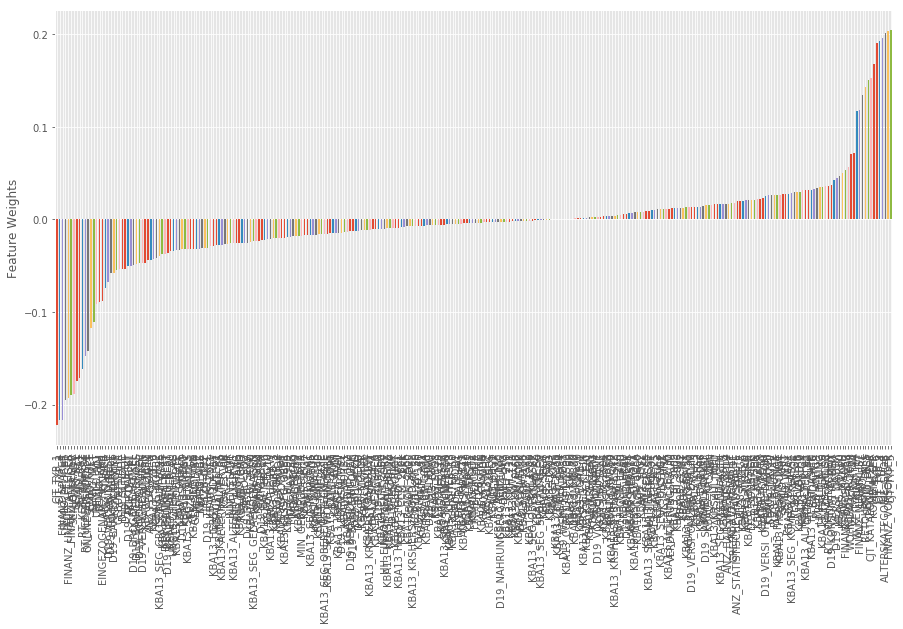

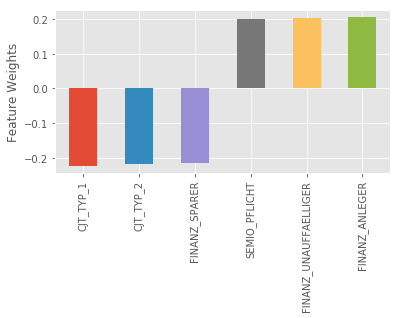

In [63]:

# coordinates of the main variables on the component 3
pca_results(clean_azdias, azdias_pca_155, 3)

In [84]:
# List of the 6 features with high cordinates in absolute value in the component 3
L3=['CJT_TYP_1','CJT_TYP_2','FINANZ_SPARER','SEMIO_PFLICHT','FINANZ_UNAUFFAELLIGER','FINANZ_ANLEGER']
map3=levels_infos.loc[levels_infos.Attribute.isin(L3),:]
del map3['Unnamed: 0']
map3

Information level              Attribute  \
5                NaN          FINANZ_SPARER   
7                NaN         FINANZ_ANLEGER   
8                NaN  FINANZ_UNAUFFAELLIGER   
36               NaN          SEMIO_PFLICHT   

                                          Description Additional notes  
5                     financial typology: money saver              NaN  
7                        financial typology: investor              NaN  
8                    financial typology: unremarkable              NaN  
36  affinity indicating in what way the person is ...              NaN

In [86]:
# List of the 6 features with high cordinates in absolute value in the component 2
L2=['KBA13_SIZE_5','KBA13_KMH_140_210','KBA13_SEG_KLEINWAGEN','KBA13_KMH_180','KBA13_HALTER_25','KBA13_HALTER_20']
map2=levels_infos.loc[levels_infos.Attribute.isin(L2),:]
del map2['Unnamed: 0']
map2


Information level             Attribute  \
223               NaN       KBA13_HALTER_20   
224               NaN       KBA13_HALTER_25   
242               NaN         KBA13_KMH_180   
244               NaN     KBA13_KMH_140_210   
278               NaN  KBA13_SEG_KLEINWAGEN   

                                           Description Additional notes  
223       share of car owners below 21 within the PLZ8              NaN  
224  share of car owners between 21 and 25 within t...              NaN  
242  share of cars with max speed between 110 km/h ...              NaN  
244  share of cars with max speed between 140 and 2...              NaN  
278  share of small and very small cars (Ford Fiest...              NaN

In [87]:
# List of the 6 features with high cordinates in absolute value in the component 1
L1=['PLZ8_ANTG1','KBA13_ANTG1','MOBI_REGIO','KBA13_AUTOQUOTE','MOBI_RASTER','KBA05_AUTOQUOT']
map1=levels_infos.loc[levels_infos.Attribute.isin(L1),:]
del map1['Unnamed: 0']
map1

Information level        Attribute  \
97   Microcell (RR3_ID)   KBA05_AUTOQUOT   
191                 NaN       MOBI_REGIO   
200                 NaN  KBA13_AUTOQUOTE   
301                 NaN       PLZ8_ANTG1   

                                     Description Additional notes  
97                   share of cars per household              NaN  
191                              moving patterns              NaN  
200  share of cars per household within the PLZ8              NaN  
301      number of 1-2 family houses in the PLZ8              NaN

##### Interpretation of the first 3 component 
Let's now interrupt the main components in the light of the results we have just displayed with the function pca_results

The above results allow us to interpret the main components 1, 2 and 3 from the data.
For each of the principal components cited, we took the three variables with positive and highest coordinates on that component and the three variables with negative and highest absolute coordinates on that component.
We then linked these variables to the information contained in the descriptive file of the various variables in the data sets provided to us.  For unknown reasons, some variables are not present in the descriptive file.

The analysis of the results indicates that:

- `component 1` is mainly related to movement and cars, more precisely to high movement and a greater number of cars.
- `Component 2` is related to the characteristics of the cars owned by customers. These characteristics are essentially the speed and size of the car. 
- `Component 3` is more related to finance.
It describes people who are investor-minded.


#### Kmeans

> Let start by fitting the 155 pca model on the customer dataset then
building an elbow graph function to determine the optimal number of cluster to take in account in the Kmeans alogorithm

In [106]:
## Fit the the azdias_pca_155 to customers data
customers_pca_155,customers_fit_pca_155= azdias_pca_155, azdias_pca_155.fit_transform(clean_customers)

In [115]:

#function to fit the kmeans model
def kmeans(data, centers):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    
    '''
    kmeans = KMeans(centers)
    model = kmeans.fit(data)
    
    # SSE score for kmeans model 
    score = np.abs(model.score(data))
    return score

In [116]:
def elbow(pca_fit_data):
    scores = []
    centers = list(range(1,20))
    i = 0
    for center in centers:
        i += 1
        print(i)
        scores.append(kmeans(pca_fit_data, center))
        
    # Investigate the change in within-cluster distance across number of clusters.
    # Plot the original data with clusters
    plt.plot(centers, scores, linestyle='--', marker='o', color='b')
    plt.ylabel('SSE score')
    plt.xlabel('K')
    plt.title('SSE vs K')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


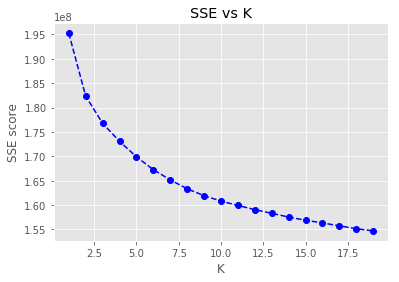

In [117]:
elbow(azdias_fit_pca_155)

> According to the resultats displayed in the `elbow` plot I decide to chose **`6 clusters`**.

In [120]:
# Fit the k-means model on the azdias data using the selected clusters number
kmeans = KMeans(6)
azdias_kmodel = kmeans.fit(azdias_fit_pca_155)
azdias_labels = azdias_kmodel.predict(azdias_fit_pca_155)

In [121]:
# display the 20 first predicted labels
azdias_labels[:20]

array([2, 2, 5, 1, 5, 2, 2, 1, 1, 5, 2, 2, 1, 4, 2, 2, 1, 5, 5, 4], dtype=int32)

In [122]:
# I use the azdias_kmodel to predict custommers classes
customers_labels=azdias_kmodel.predict(customers_fit_pca_155)


In [123]:
# display 20 first custommers classes
customers_labels[:20]

array([0, 4, 0, 1, 3, 0, 3, 4, 5, 5, 0, 4, 5, 3, 5, 4, 5, 4, 0, 4], dtype=int32)

> Now let compare the customers data clusters with the demographics data clusters.


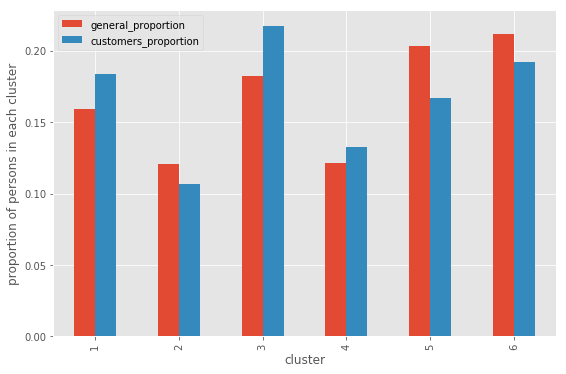

In [124]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_pop = []
customers_pop = []
x = [i+1 for i in range(6)]
for i in range(6):
    general_pop.append((azdias_labels == i).sum()/len(azdias_labels))
    customers_pop.append((customers_labels == i).sum()/len(customers_labels))


df_general = pd.DataFrame({'cluster' : x, 'general_proportion' : general_pop, 'customers_proportion':customers_pop})

df_general.plot(x='cluster', y = ['general_proportion', 'customers_proportion'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()

> As we can see, the `cluster 3` is the most overrepresented cluster in the customer data. This segment should be the company's target market in the general population

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographics information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [171]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [172]:
# Use the data_cleaning function to perform the cleaning and features engineering 
train = data_cleaning(mailout_train, df_unknowns)

In [173]:
train.head()

LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  \
0  1763.0         1.0                 15.0           0.0         0.0   
1  1771.0         4.0                  1.0           0.0         0.0   
2  1776.0         1.0                  0.0           NaN         0.0   
3  1460.0         1.0                  4.0           0.0         0.0   
4  1783.0         1.0                 53.0           0.0         0.0   

   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL  ARBEIT  BALLRAUM  \
0           1.0                        13.0        0.0     3.0       5.0   
1           2.0                         1.0        0.0     2.0       5.0   
2           0.0                         1.0        0.0     4.0       1.0   
3           2.0                         4.0        0.0     4.0       2.0   
4           1.0                        44.0        0.0     3.0       4.0   

  CAMEO_DEUG_2015 CAMEO_INTL_2015  CJT_GESAMTTYP  CJT_KATALOGNUTZER  \
0               5              34            2.0                5.0   
1               5              32            2.0                2.0   
2               2              14            4.0                5.0   
3               2              14            2.0                5.0   
4               7              41            6.0                5.0   

   CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  \
0        2.0        2.0        5.0        5.0        5.0        5.0   
1        2.0        2.0        4.0        3.0        5.0        4.0   
2        1.0        1.0        5.0        5.0        5.0        5.0   
3        2.0        2.0        5.0        5.0        5.0        4.0   
4        1.0        2.0        5.0        5.0        5.0        5.0   

   D19_BANKEN_DIREKT  D19_BANKEN_GROSS  D19_BANKEN_LOKAL  D19_BANKEN_REST  \
0                0.0               0.0               0.0              0.0   
1                0.0               0.0               3.0              0.0   
2                0.0               0.0               0.0              5.0   
3                0.0               0.0               0.0              0.0   
4                0.0               0.0               0.0              0.0   

   D19_BEKLEIDUNG_GEH  D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  \
0                 0.0                  0.0          0.0           0.0   
1                 0.0                  6.0          0.0           0.0   
2                 0.0                  0.0          0.0           0.0   
3                 0.0                  6.0          0.0           0.0   
4                 5.0                  0.0          7.0           0.0   

   D19_BUCH_CD  D19_DIGIT_SERV  D19_DROGERIEARTIKEL  D19_ENERGIE  \
0          0.0             0.0                  0.0          0.0   
1          0.0             0.0                  6.0          0.0   
2          0.0             0.0                  0.0          0.0   
3          6.0             0.0                  0.0          0.0   
4          0.0             0.0                  0.0          0.0   

   D19_FREIZEIT  D19_GARTEN  D19_HANDWERK  D19_HAUS_DEKO  D19_KINDERARTIKEL  \
0           0.0         0.0           0.0            0.0                0.0   
1           0.0         0.0           6.0            6.0                0.0   
2           0.0         0.0           0.0            0.0                0.0   
3           0.0         0.0           0.0            0.0                0.0   
4           0.0         0.0           0.0            0.0                0.0   

   D19_KONSUMTYP_MAX  D19_KOSMETIK  D19_LEBENSMITTEL  D19_NAHRUNGSERGAENZUNG  \
0                2.0           7.0               0.0                     0.0   
1                4.0           6.0               0.0                     0.0   
2                2.0           0.0               5.0                     0.0   
3                2.0           7.0               0.0                     0.0   
4                2.0           0.0               0.0                     0.0

In [174]:
train_y=train['RESPONSE']
train_x=train.loc[:, train.columns != 'RESPONSE']
print(f'shape of the train target: {train_y.shape} \nshape of train_x: {train_x.shape}')

shape of the train target: (33931,) 
shape of train_x: (33931, 312)


In [175]:
count=train_y.value_counts()
prop_0= count[0]/train_y.shape[0]
prop_1= count[1]/train_y.shape[0]
print(f'The proportion of 0 class is :  {prop_0}\nThe proportion of 1 class is:  {prop_1}')

The proportion of 0 class is :  0.9876514102148478
The proportion of 1 class is:  0.012348589785152221


> We are in front of an imbalanced classification problem. The distribution accros the two class is  not equal
That's why the choice of the `AUC` as better suited here compared to others such as the `accuracy`.  For more details see [David S. Batista](http://www.davidsbatista.net/blog/2018/08/19/NLP_Metrics/) post

In [176]:
# Remove the three columns containing 'X' and 'XX'
for col in ['CAMEO_DEUG_2015','CAMEO_INTL_2015','EINGEFUEGT_AM']:
    if col in train_x.columns:
        del train_x[col]

In [177]:
## Impute missing value
imputer = Imputer(strategy='mean')
train_X = pd.DataFrame(imputer.fit_transform(train_x), columns = train_x.columns)
train_X.head()

LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  \
0  1763.0         1.0                 15.0      0.000000         0.0   
1  1771.0         4.0                  1.0      0.000000         0.0   
2  1776.0         1.0                  0.0      0.048078         0.0   
3  1460.0         1.0                  4.0      0.000000         0.0   
4  1783.0         1.0                 53.0      0.000000         0.0   

   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL  ARBEIT  BALLRAUM  \
0           1.0                        13.0        0.0     3.0       5.0   
1           2.0                         1.0        0.0     2.0       5.0   
2           0.0                         1.0        0.0     4.0       1.0   
3           2.0                         4.0        0.0     4.0       2.0   
4           1.0                        44.0        0.0     3.0       4.0   

   CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  \
0            2.0                5.0        2.0        2.0        5.0   
1            2.0                2.0        2.0        2.0        4.0   
2            4.0                5.0        1.0        1.0        5.0   
3            2.0                5.0        2.0        2.0        5.0   
4            6.0                5.0        1.0        2.0        5.0   

   CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  \
0        5.0        5.0        5.0                0.0               0.0   
1        3.0        5.0        4.0                0.0               0.0   
2        5.0        5.0        5.0                0.0               0.0   
3        5.0        5.0        4.0                0.0               0.0   
4        5.0        5.0        5.0                0.0               0.0   

   D19_BANKEN_LOKAL  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  D19_BEKLEIDUNG_REST  \
0               0.0              0.0                 0.0                  0.0   
1               3.0              0.0                 0.0                  6.0   
2               0.0              5.0                 0.0                  0.0   
3               0.0              0.0                 0.0                  6.0   
4               0.0              0.0                 5.0                  0.0   

   D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  D19_DIGIT_SERV  \
0          0.0           0.0          0.0             0.0   
1          0.0           0.0          0.0             0.0   
2          0.0           0.0          0.0             0.0   
3          0.0           0.0          6.0             0.0   
4          7.0           0.0          0.0             0.0   

   D19_DROGERIEARTIKEL  D19_ENERGIE  D19_FREIZEIT  D19_GARTEN  D19_HANDWERK  \
0                  0.0          0.0           0.0         0.0           0.0   
1                  6.0          0.0           0.0         0.0           6.0   
2                  0.0          0.0           0.0         0.0           0.0   
3                  0.0          0.0           0.0         0.0           0.0   
4                  0.0          0.0           0.0         0.0           0.0   

   D19_HAUS_DEKO  D19_KINDERARTIKEL  D19_KONSUMTYP_MAX  D19_KOSMETIK  \
0            0.0                0.0                2.0           7.0   
1            6.0                0.0                4.0           6.0   
2            0.0                0.0                2.0           0.0   
3            0.0                0.0                2.0           7.0   
4            0.0                0.0                2.0           0.0   

   D19_LEBENSMITTEL  D19_NAHRUNGSERGAENZUNG  D19_RATGEBER  D19_REISEN  \
0               0.0                     0.0           0.0         0.0   
1               0.0                     0.0           0.0         0.0   
2               5.0                     0.0           0.0         0.0   
3               0.0                     0.0           0.0         0.0   
4               0.0                     0.0           2.0         0.0   

   D19_SAMMELARTIKEL  D19_SCHUH

In [178]:
# scaling features
scaler = StandardScaler()
train_XX = pd.DataFrame(scaler.fit_transform(train_X), columns = train_X.columns)
train_XX.head()
print()
print(train_XX.shape)


(33931, 309)


> Now the I am ready to perform supervised learning models on the cleaned training dataset.
I will create a function to facilitate the modelling steps. In this function I use GridShearchCV to find the optimal hyperparmeters of the differents models.

In [179]:
def supervised_classifier(clf, param_grid, X=train_XX, y=train_y):
    """
    Fit a classifier using GridSearchCV and calculates ROC AUC
    
    INPUT:
    - clf (model): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X (DataFrame): features of the training dataframe
    - y (DataFrame): labels of the training dataframe
            
    OUTPUT:
    - classifier: fitted classifier
    - prints elapsed time and ROX AUC
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    
    start = time.time()
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=10)
    grid.fit(X, y)
    print('Time', (time.time()- start), 'seconds')

    print(grid.best_score_)
    
    return grid.best_estimator_

#### Logistic regression
> I will begin with a logistic regression 


In [182]:
logistic_model = LogisticRegression(random_state=10, solver='lbfgs', class_weight={0: 0.98, 1: 0.012})
print(supervised_classifier(logistic_model,{}))

Time 9.824196338653564 seconds
0.659610507199
LogisticRegression(C=1.0, class_weight={0: 0.98, 1: 0.012}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=10,
          solver='lbfgs', tol=1e-06, verbose=0, warm_start=False)


#### Random Forest
 Let perform a random forest and tune the hyperparmeters with GridSearchCV

In [216]:
rf_model= RandomForestClassifier()

print(supervised_classifier(rf_model,{}))

Time 1385.6225943565369 seconds
0.595524044748
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


#### Adaboost classifier

In [215]:
adaBoost_model = AdaBoostClassifier()
print(supervised_classifier(adaBoost_model, {}))

Time 146.25855922698975 seconds
0.688883387635
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


#### Gradient boosting classifier


In [208]:
gb_model = GradientBoostingClassifier()
print(supervised_classifier(gb_model, {}))

Time 393.4369041919708 seconds
0.700244118201
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


#### SVM classifier



In [212]:
svc_model = LinearSVC(loss='hinge')
print(supervised_classifier(svc_model, {}))

Time 401.3666834831238 seconds
0.494935695079
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)


#### Stochastic Gradient Descent **`SGDClassifier`**

In [213]:
SGD_model=SGDClassifier(loss='hinge')
print(supervised_classifier(SGD_model, {}))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/s

Time 3.358182907104492 seconds
0.633240257345
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


#### Extreme gradient boosting (XGboost)

> I first install the xgboost package. Then I use it paying attention to set the objective parameter to `'binary:logistic'`. 


In [323]:
X_train, X_val, y_train, y_val = train_test_split(train_XX, train_y, stratify=train_y, test_size=0.3, random_state=12)

In [321]:
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=50, seed=123)
xg_cl.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=50, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=123, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
       tree_method=None, validate_parameters=False, verbosity=None)

In [327]:
clf = xgb.XGBClassifier(n_estimators=10000)
eval_set  = [(X_train,y_train), (X_val,y_val)]
clf.fit(X_train, y_train, eval_set=eval_set, eval_metric="auc", early_stopping_rounds=30)

[0]	validation_0-auc:0.64045	validation_1-auc:0.65596
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.71773	validation_1-auc:0.71613
[2]	validation_0-auc:0.74050	validation_1-auc:0.71500
[3]	validation_0-auc:0.75121	validation_1-auc:0.70920
[4]	validation_0-auc:0.75709	validation_1-auc:0.70933
[5]	validation_0-auc:0.77749	validation_1-auc:0.70771
[6]	validation_0-auc:0.81444	validation_1-auc:0.70509
[7]	validation_0-auc:0.84586	validation_1-auc:0.70532
[8]	validation_0-auc:0.86795	validation_1-auc:0.71318
[9]	validation_0-auc:0.89819	validation_1-auc:0.71193
[10]	validation_0-auc:0.90801	validation_1-auc:0.69900
[11]	validation_0-auc:0.93205	validation_1-auc:0.69681
[12]	validation_0-auc:0.94674	validation_1-auc:0.71646
[13]	validation_0-auc:0.95835	validation_1-auc:0.70942
[14]	validation_0-auc:0.96647	validation_1-auc:0.70885
[15]	validation_0-auc:0.9725

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=10000, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

In [303]:
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_val, y_val)
params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "eta": 0.1,
        "tree_method": 'exact',
        "max_depth": 6,
        "subsample": 1,
        "colsample_bytree": 1,
        "silent": 1,
        "min_chil_weight":1,
        "seed": 123,
    }
num_boost_round = 500
early_stopping_rounds = 100
test_size = 0.3
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

[0]	train-auc:0.64045	eval-auc:0.65596
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[1]	train-auc:0.68870	eval-auc:0.70838
[2]	train-auc:0.71466	eval-auc:0.71632
[3]	train-auc:0.72725	eval-auc:0.71679
[4]	train-auc:0.73038	eval-auc:0.71659
[5]	train-auc:0.73551	eval-auc:0.71376
[6]	train-auc:0.73656	eval-auc:0.71244
[7]	train-auc:0.73701	eval-auc:0.71385
[8]	train-auc:0.74188	eval-auc:0.71533
[9]	train-auc:0.74986	eval-auc:0.71282
[10]	train-auc:0.75417	eval-auc:0.71071
[11]	train-auc:0.75887	eval-auc:0.70860
[12]	train-auc:0.76337	eval-auc:0.71104
[13]	train-auc:0.76953	eval-auc:0.70827
[14]	train-auc:0.77237	eval-auc:0.70956
[15]	train-auc:0.77548	eval-auc:0.70833
[16]	train-auc:0.78965	eval-auc:0.70519
[17]	train-auc:0.79661	eval-auc:0.70431
[18]	train-auc:0.80083	eval-auc:0.70792
[19]	train-auc:0.80684	eval-auc:0.70739
[20]	train-auc:0.83649	eval-auc:0.71052
[21]	train-auc:0.84929	eval-

In [328]:
pred = gbm.predict(xgb.DMatrix(X_val), ntree_limit=gbm.best_iteration+1)
fpr, tpr, _ = roc_curve(y_val, pred)
roc_auc = auc(fpr, tpr)
roc_auc


0.71679320557876358

#### Summary : Results of the differents models

| Models  | ROC AUC  |
|:---------:|---|
| Logistic regression  |0.66   |
| Random Forest  | 0.596  |
| Adaboost classifier  |   0.689|
| Gradient boosting classifier(sklearn)  |0.70   |
| SVM  |   0.495|
| Stochastic Gradient Descent SGDClassifier  |   0.63|
| Extreme gradient boosting (XGboost)  |  0.717|

> As we can see, the `xgboost` model has the highest `ROC AUC(0.717)` followed by the `Gradient boosting classifier(0.70)` and the  `Adaboost classifier(0.689)`.
The ensemble models perform better  than the others models here.

> I will try to tune the hyperparameters of the xgboost in particular its XGBClassifier variant present in sklearn in order to take advantage of sklearn's GridShearCV tuning method . Then  I will use the best founded parameters for the final prediction as it as the best ROC AUC score.

In [356]:
tuned_parameters = {'learning_rate': [0.4,0.5],
        'max_depth': [6,7]
    }

fit_params={
    "eval_set":[(X_train, y_train),(X_val,y_val)],
    "eval_metric": 'auc',
    "early_stopping_rounds":100,
    "verbose":True
}



model = xgb.XGBClassifier( objective ='binary:logistic',  seed=0,n_estimators=1000 )
gridsearch = GridSearchCV(model, tuned_parameters, verbose=999999 ,
    scoring='roc_auc',
    fit_params=fit_params
    )
gridsearch.fit(train_XX, train_y)

print (gridsearch.best_params_)
print (gridsearch.best_score_)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate=0.4, max_depth=6 ..................................
[0]	validation_0-auc:0.64045	validation_1-auc:0.65596
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.72344	validation_1-auc:0.72304
[2]	validation_0-auc:0.73616	validation_1-auc:0.73830
[3]	validation_0-auc:0.74867	validation_1-auc:0.74741
[4]	validation_0-auc:0.76294	validation_1-auc:0.75555
[5]	validation_0-auc:0.77221	validation_1-auc:0.77741
[6]	validation_0-auc:0.79615	validation_1-auc:0.80910
[7]	validation_0-auc:0.80955	validation_1-auc:0.82891
[8]	validation_0-auc:0.81903	validation_1-auc:0.85329
[9]	validation_0-auc:0.82551	validation_1-auc:0.87443
[10]	validation_0-auc:0.83813	validation_1-auc:0.87638
[11]	validation_0-auc:0.84319	validation_1-auc:0.89272
[12]	validation_0-auc:0.85269	validation_1-auc:0.89899
[13]	v

> The parameters tuning gives `'learning_rate': 0.4` and `'max_depth': 7` as the optimal parameters to use.
I will train the final xgboost model with theses parameters

In [386]:

## Optimal training model
optim_model = xgb.XGBClassifier(objective ='binary:logistic',  n_estimators=10000, seed=0,max_depth=7,learning_rate=0.4)
eval_set  = [(X_train,y_train), (X_val,y_val)]
optim_model.fit(X_train, y_train, eval_set=eval_set, eval_metric="auc", early_stopping_rounds=30)

[0]	validation_0-auc:0.64045	validation_1-auc:0.65596
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.71874	validation_1-auc:0.71569
[2]	validation_0-auc:0.75025	validation_1-auc:0.71440
[3]	validation_0-auc:0.77739	validation_1-auc:0.70662
[4]	validation_0-auc:0.80082	validation_1-auc:0.70296
[5]	validation_0-auc:0.86913	validation_1-auc:0.70191
[6]	validation_0-auc:0.89161	validation_1-auc:0.69877
[7]	validation_0-auc:0.92513	validation_1-auc:0.69014
[8]	validation_0-auc:0.95290	validation_1-auc:0.67278
[9]	validation_0-auc:0.96543	validation_1-auc:0.68177
[10]	validation_0-auc:0.97592	validation_1-auc:0.67757
[11]	validation_0-auc:0.98136	validation_1-auc:0.68061
[12]	validation_0-auc:0.98864	validation_1-auc:0.68155
[13]	validation_0-auc:0.99339	validation_1-auc:0.68822
[14]	validation_0-auc:0.99563	validation_1-auc:0.68808
[15]	validation_0-auc:0.9965

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.4, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=10000, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, subsample=1,
       tree_method=None, validate_parameters=False, verbosity=None)

Parameter tuning did not allow a substantial gain in AUC. We go from `0.717` AUC without tuning to `0.715` AUC with tuning. However, the optimal parameters found with tuning are interesting in that they avoid overfitting. Indeed we can see that with parameter tuning the AUC deviation between the training dataset and the validation dataset is very small(**training AUC: 0.71874**, **validation AUC:0.71569**). On the other hand, this difference is a little higher without the tuning (**training AUC: 0.94674**, **validation AUC:0.71646**)



## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [373]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test.shape

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(42833, 366)

In [379]:
mailout_test.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  1754         2         1.0       7.0          NaN          NaN   
1  1770        -1         1.0       0.0          NaN          NaN   
2  1465         2         9.0      16.0          NaN          NaN   
3  1470        -1         7.0       0.0          NaN          NaN   
4  1478         1         1.0      21.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   6.0                  2.0   
1          NaN          NaN                   0.0                 20.0   
2          NaN          NaN                  11.0                  2.0   
3          NaN          NaN                   0.0                  1.0   
4          NaN          NaN                  13.0                  1.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           0.0         0.0           2.0                         2.0   
1           0.0         0.0           1.0                        21.0   
2           0.0         0.0           4.0                         2.0   
3           0.0         0.0           0.0                         1.0   
4           0.0         0.0           4.0                         1.0   

   ANZ_TITEL  ARBEIT  BALLRAUM CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  \
0        0.0     3.0       6.0             2B               2              13   
1        0.0     4.0       7.0             5A               5              31   
2        0.0     4.0       1.0             7A               7              41   
3        0.0     4.0       1.0             2B               2              13   
4        0.0     3.0       6.0             5A               5              31   

   CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  \
0            5.0                5.0        1.0        2.0        5.0   
1            1.0                5.0        2.0        2.0        5.0   
2            2.0                5.0        2.0        2.0        5.0   
3            4.0                5.0        2.0        1.0        5.0   
4            6.0                1.0        3.0        2.0        4.0   

   CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  \
0        5.0        5.0        5.0                  0                  0   
1        5.0        4.0        5.0                  0                  0   
2        5.0        5.0        5.0                  0                  0   
3        5.0        5.0        5.0                  0                  0   
4        4.0        4.0        3.0                  3                  4   

   D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  D19_BANKEN_LOKAL  \
0                10                  0                 0                 0   
1                10                  0                 0                 0   
2                10                  0                 0                 0   
3                10                  0                 0                 0   
4                 2                  2                 2                 0   

   D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
0                        10                       10   
1                        10                       10   
2                        10                       10   
3                        10                       10   
4                         8                        2   

   D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  \
0                         0.0                0                   3   
1                         0.0                0                   0   
2                         0.0                0                   0   
3                         0.0                0                   0   
4                        10.0                6                   6   

   D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  \
0                    6            0

In [375]:
## I define a test data cleaning because here I must notre remove individuals.
# I have to make prediction for all individuals
def test_data_cleaning(df_to_clean, df_vars_unknowns):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: 
        df_to_clean: Customer demographics DataFrame
        df_vars_unknowns: Unknowns DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    for col in df_to_clean.columns:
        if df_to_clean[col].dtype == np.int64:
            df_to_clean[col] = df_to_clean[col].astype(np.float64)
        
    # convert missing value codes into NaNs, ...
    for row in df_vars_unknowns['Attribute']:
        if row in df_to_clean.columns:
            na_map = df_vars_unknowns.loc[df_vars_unknowns['Attribute'] == row, 'Unknown'].iloc[0]
            na_idx = df_to_clean.loc[:, row].isin(na_map)
            df_to_clean.loc[na_idx, row] = np.NaN
        else:
            continue
            
    # Remove columns which have more than 20 %  missing values in the azdias dataframe
    columns_to_drop = pd.read_csv('columns_to_drop.csv')
    cols_to_drop    =list(columns_to_drop['columns_to_drop'])
    for col in cols_to_drop:
        if col in df_to_clean.columns:
            del df_to_clean[col]
    
    # select, re-encode, and engineer column values
    df_to_clean['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

    cols_to_dummy = list(pd.read_csv('cols_to_dummy.csv').cols_to_dummy)
    
    for col in cols_to_dummy:
        dummy = pd.get_dummies(df_to_clean[col], prefix = col)
        df_to_clean = pd.concat([df_to_clean, dummy], axis = 1)
        
    df_to_clean.drop(cols_to_dummy, axis=1, inplace = True)
    return df_to_clean



In [381]:
# Test data cleaning
test_clean= test_data_cleaning(mailout_test,df_unknowns)

LNR= test_clean['LNR']

In [383]:
# Remove the three columns containing 'X' and 'XX'
for col in ['CAMEO_DEUG_2015','CAMEO_INTL_2015','EINGEFUEGT_AM']:
    if col in test_clean.columns:
        del test_clean[col]

In [384]:
# Impute missing values
test_X = pd.DataFrame(imputer.transform(test_clean), columns = test_clean.columns)
test_X.head()

LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  \
0  1754.0         1.0                  2.0           0.0         0.0   
1  1770.0         1.0                 20.0           0.0         0.0   
2  1465.0         9.0                  2.0           0.0         0.0   
3  1470.0         7.0                  1.0           0.0         0.0   
4  1478.0         1.0                  1.0           0.0         0.0   

   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL  ARBEIT  BALLRAUM  \
0           2.0                         2.0        0.0     3.0       6.0   
1           1.0                        21.0        0.0     4.0       7.0   
2           4.0                         2.0        0.0     4.0       1.0   
3           0.0                         1.0        0.0     4.0       1.0   
4           4.0                         1.0        0.0     3.0       6.0   

   CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  \
0            5.0                5.0        1.0        2.0        5.0   
1            1.0                5.0        2.0        2.0        5.0   
2            2.0                5.0        2.0        2.0        5.0   
3            4.0                5.0        2.0        1.0        5.0   
4            6.0                1.0        3.0        2.0        4.0   

   CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  \
0        5.0        5.0        5.0                0.0               0.0   
1        5.0        4.0        5.0                0.0               0.0   
2        5.0        5.0        5.0                0.0               0.0   
3        5.0        5.0        5.0                0.0               0.0   
4        4.0        4.0        3.0                2.0               2.0   

   D19_BANKEN_LOKAL  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  D19_BEKLEIDUNG_REST  \
0               0.0              0.0                 3.0                  6.0   
1               0.0              0.0                 0.0                  6.0   
2               0.0              0.0                 0.0                  0.0   
3               0.0              0.0                 0.0                  0.0   
4               0.0              6.0                 6.0                  6.0   

   D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  D19_DIGIT_SERV  \
0          0.0           0.0          0.0             0.0   
1          0.0           0.0          7.0             0.0   
2          0.0           0.0          6.0             0.0   
3          0.0           0.0          0.0             0.0   
4          5.0           0.0          3.0             0.0   

   D19_DROGERIEARTIKEL  D19_ENERGIE  D19_FREIZEIT  D19_GARTEN  D19_HANDWERK  \
0                  6.0          0.0           0.0         0.0           0.0   
1                  0.0          0.0           0.0         0.0           0.0   
2                  0.0          0.0           0.0         0.0           7.0   
3                  0.0          0.0           0.0         6.0           0.0   
4                  2.0          0.0           5.0         5.0           7.0   

   D19_HAUS_DEKO  D19_KINDERARTIKEL  D19_KONSUMTYP_MAX  D19_KOSMETIK  \
0            6.0                0.0                2.0           6.0   
1            6.0                0.0                2.0           6.0   
2            0.0                0.0                8.0           0.0   
3            0.0                0.0                8.0           6.0   
4            2.0                5.0                1.0           7.0   

   D19_LEBENSMITTEL  D19_NAHRUNGSERGAENZUNG  D19_RATGEBER  D19_REISEN  \
0               0.0                     0.0           0.0         0.0   
1               0.0                     0.0           0.0         0.0   
2               0.0                     0.0           0.0         6.0   
3               6.0                     6.0           0.0         0.0   
4               0.0                     0.0           6.0         6.0   

   D19_SAMMELARTIKEL  D19_SCHUH

In [385]:
# Scaling
test_XX = pd.DataFrame(scaler.transform(test_X), columns = test_X.columns)
test_XX.head()

LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  \
0 -1.651325   -0.291892            -0.306990     -0.130854   -0.221209   
1 -1.650683   -0.291892             0.900733     -0.130854   -0.221209   
2 -1.662922    4.436201            -0.306990     -0.130854   -0.221209   
3 -1.662722    3.254178            -0.374085     -0.130854   -0.221209   
4 -1.662401   -0.291892            -0.374085     -0.130854   -0.221209   

   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL    ARBEIT  BALLRAUM  \
0     -0.024173                   -0.295013  -0.091527 -0.042065  0.793361   
1     -0.757150                    1.067830  -0.091527  0.926806  1.249238   
2      1.441783                   -0.295013  -0.091527  0.926806 -1.486020   
3     -1.490128                   -0.366742  -0.091527  0.926806 -1.486020   
4      1.441783                   -0.366742  -0.091527 -0.042065  0.793361   

   CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  \
0       1.404993           0.873202  -1.142786   0.142217   0.628161   
1      -1.246746           0.873202  -0.140321   0.142217   0.628161   
2      -0.583811           0.873202  -0.140321   0.142217   0.628161   
3       0.742058           0.873202  -0.140321  -0.903122   0.628161   
4       2.067928          -1.855211   0.862145   0.142217  -0.414856   

   CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  \
0   0.649180   0.635214   0.645182          -0.428600         -0.342055   
1   0.649180  -0.377044   0.645182          -0.428600         -0.342055   
2   0.649180   0.635214   0.645182          -0.428600         -0.342055   
3   0.649180   0.635214   0.645182          -0.428600         -0.342055   
4  -0.254692  -0.377044  -1.322746           0.592882          0.904389   

   D19_BANKEN_LOKAL  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  D19_BEKLEIDUNG_REST  \
0         -0.142965        -0.290773            0.960778             1.451689   
1         -0.142965        -0.290773           -0.465280             1.451689   
2         -0.142965        -0.290773           -0.465280            -0.715466   
3         -0.142965        -0.290773           -0.465280            -0.715466   
4         -0.142965         3.625950            2.386835             1.451689   

   D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  D19_DIGIT_SERV  \
0    -0.509085     -0.375364    -1.062426       -0.214552   
1    -0.509085     -0.375364     1.391997       -0.214552   
2    -0.509085     -0.375364     1.041365       -0.214552   
3    -0.509085     -0.375364    -1.062426       -0.214552   
4     1.579286     -0.375364    -0.010530       -0.214552   

   D19_DROGERIEARTIKEL  D19_ENERGIE  D19_FREIZEIT  D19_GARTEN  D19_HANDWERK  \
0             2.717766    -0.329226     -0.395238   -0.303902     -0.704020   
1            -0.426658    -0.329226     -0.395238   -0.303902     -0.704020   
2            -0.426658    -0.329226     -0.395238   -0.303902      1.710417   
3            -0.426658    -0.329226     -0.395238    3.474896     -0.704020   
4             0.621483    -0.329226      2.305290    2.845097      1.710417   

   D19_HAUS_DEKO  D19_KINDERARTIKEL  D19_KONSUMTYP_MAX  D19_KOSMETIK  \
0       1.568349          -0.559381          -0.622148      1.087551   
1       1.568349          -0.559381          -0.622148      1.087551   
2      -0.749507          -0.559381           1.515114     -0.802662   
3      -0.749507          -0.559381           1.515114      1.087551   
4       0.023112           1.440908          -0.978358      1.402586   

   D19_LEBENSMITTEL  D19_NAHRUNGSERGAENZUNG  D19_RATGEBER  D19_REISEN  \
0         -0.409764               -0.365069     -0.491726   -0.819710   
1         -0.409764               -0.365069     -0.491726   -0.819710   
2         -0.409764               -0.365069     -0.491726    1.153351   
3          2.593306                2.858516     -0.491726   -0.819710   
4         -0.409764               -0.365069      2.210988    1.153351   

   D19_SA

In [387]:
pred_proba= optim_model.predict_proba(
                                    test_XX,
                                    ntree_limit = optim_model.best_ntree_limit
                                )

In [389]:
pred_proba[:15]

array([[ 0.78921902,  0.21078095],
       [ 0.78921902,  0.21078095],
       [ 0.79670972,  0.2032903 ],
       [ 0.79670972,  0.2032903 ],
       [ 0.79320455,  0.20679545],
       [ 0.79670972,  0.2032903 ],
       [ 0.78921902,  0.21078095],
       [ 0.64078093,  0.3592191 ],
       [ 0.78921902,  0.21078095],
       [ 0.79320455,  0.20679545],
       [ 0.79670972,  0.2032903 ],
       [ 0.78458071,  0.21541929],
       [ 0.79320455,  0.20679545],
       [ 0.78921902,  0.21078095],
       [ 0.78921902,  0.21078095]], dtype=float32)

#### Kaggle submission

In [390]:
kaggle_submission = pd.DataFrame({'LNR':LNR.astype(np.int32), 'RESPONSE':pred_proba[:, 1]})
kaggle_submission.to_csv('kaggle.csv', index = False)
kaggle_submission.head()

LNR  RESPONSE
0  1754  0.210781
1  1770  0.210781
2  1465  0.203290
3  1470  0.203290
4  1478  0.206795